<a href="https://colab.research.google.com/github/marcinwolter/MedicalPictures/blob/master/figure_jpeg_cnn_reco_JPEG_NEAREST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code generating geometrical figures and performing pattern recognition using Deep NN

*Feb. 2020, Marcin Wolter*

In [21]:
'''Trains a simple convnet on the generated set of figures (circle, triangle, square)
'''
from __future__ import print_function

# install keras
!pip install -U keras
#install KERAS if not there
!pip install keras_sequential_ascii

import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation
from keras import backend as K
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from PIL import Image, ImageDraw

import time
import math



Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


# **Mount google disk**

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prevent Google Colab from disconnecting

In [23]:
from IPython.display import display, HTML
js = ('<script>function ConnectButton(){ '
           'console.log("Connect pushed"); '
           'document.querySelector("#connect").click()} '
           'setInterval(ConnectButton,3000);</script>')
display(HTML(js))

# **Setup the parameters**

In [24]:
# DNN parameters
batch_size = 128
# number of classes
num_classes = 2
epochs = 256 #12

np.random.seed(2348)

#batch_size_gen = 60000
#batch_size_val = 10000
batch_size_gen = 60000
batch_size_val = 10000

# input image dimensions
img_rows, img_cols = 32, 32
img_shape = (img_rows, img_cols)


#probability of noise and its max. brithness 
prob_noise = 1.0
ampl_noise = 0.3


# figure min and max brithness
fig_min_gray=0.4
fig_max_gray=0.9

#figure sizes
# circle radius
rmin = 0.06
rmax = 0.15
# triangle/rectangle size
dmin = 0.10
dmax = 0.30
# colon / line dot radius in pixels
rpix_min = 0.5
rpix_max = 3

# distortion type
###distortion = "blur"
distortion = "jpeg"
# jpeg_format: jpeg / JPEG2000   - WARNING:  JPEG 2000 does not work on Kaggle!!!!
jpeg_format = "jpeg"
#jpeg_format = 'JPEG2000'
#jpeg_format="jpx"
# distortion - bluring sigma
sigma = (1.8,1.8)
#jpeg compression
jpeg_compression_list = [97, 80, 32, 15, 7, 3]   
jpeg2000_compression_list = [[1],[2],[4],[8],[16],[32]] 


# extrapolate True/False
extrapolate = True
# list of extrapolation factors
extrapolation_list = [0.50, 1., 2.]
###extrapolation_list = [1.]

# Generated 32x32 small image is pasted on a big image, which is a subject of
# graphical operations (jpeg compression, scaling etc). Then it is cropped out
# of it. The big image size is defined here:
bigIm_shape = (512, 512)
smallIm_X = 240
smallIm_Y = 240
# number of images to test the size
n_big = 500

#resample method BICUBIC/NEAREST/BILINEAR
#method = Image.BICUBIC
#method = Image.BILINEAR
method = Image.NEAREST

#Remove the saved DNN
! rm best_model.h5
# make directory to store images
! mkdir images
! rm images/*

rm: cannot remove 'best_model.h5': No such file or directory
mkdir: cannot create directory ‘images’: File exists
rm: cannot remove 'images/*': No such file or directory


# **Generate noise**

In [0]:
def gen_noise(batch_size_gen=batch_size_gen, img_shape=img_shape, prob_noise=prob_noise):

        batch_events = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        for n in range(batch_size_gen):

            for i in range(img_shape[0]):
               for j in range(img_shape[1]):
                 if np.random.random()<prob_noise:
                     batch_events[n,0,i,j]= min(1.,max(0.,ampl_noise*np.random.randn()))


        yield batch_events


#  Generate geometrical figures - circle, triangle, square, colon, line

In [0]:

### generate geometrical figures

def generate_circle(r, x0, y0, img_shape):
    """
    Generate a single circle.
    Parameters:
        r: radius
        x0,y0: position of the circle center
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-r, y0-r, x0+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255
    
    #print(x)
    return x

In [0]:
def generate_square(d, x0, y0, angle, img_shape):
    """
    Generate a square.
    Parameters:
        d: size
        x0,y0: position of the square center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-d/2, y0-d/2, x0+d/2, y0+d/2), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x




In [0]:
def generate_triangle(d, x0, y0, angle, img_shape):
    """
    Generate a triangle.
    Parameters:
        d: size 
        x0,y0: position of the triangle center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel grayscale
    draw = ImageDraw.Draw(image)
    dd = d/math.sqrt(3)
    draw.polygon(((x0-d/2, y0-dd/2), (x0+d/2, y0-dd/2), (x0,y0+dd)), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255.
    
    #print(x)
    return x



In [0]:
def generate_line(r, x0, y0, angle, img_shape):
    """
    Generate a line.
    Parameters:
        r: width, length = 5*r
        x0,y0: position of the line center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-2.5*r, y0-r, x0+2.5*r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [0]:
def generate_colon(r, x0, y0, angle, img_shape):
    """
    Generate a colon.
    Parameters:
        r: dot radius
        x0,y0: position of the colon center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-1.5*r-r, y0-r, x0-1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    draw.ellipse((x0+1.5*r-r, y0-r, x0+1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [0]:


# generate a random number
def rand_interval(a = 0., b = 1.):
   rnd = a + (b-a)*np.random.random()
   return rnd


# **Random figure generator**

In [0]:
# Generator for random figures
# Each image contains exactly one object (circle, triangle, square)
def gen_n_figures(batch_size_gen=batch_size_gen, img_shape=img_shape):

        batch_events  = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        batch_targets =-np.ones((batch_size_gen, 1, 1 ))

        for n in range(batch_size_gen):
            
            k = np.random.randint(0,num_classes)

            
            rpix = rand_interval(rpix_min,rpix_max)
            r = rand_interval(img_cols*rmin, img_cols*rmax)
            d = rand_interval(img_cols*dmin, img_cols*dmax) 
            l = rand_interval(img_cols*dmin, img_cols*dmax)
            x0 = rand_interval(0.33*img_cols, 0.66*img_cols)       
            y0 = rand_interval(0.33*img_rows, 0.66*img_rows)     
            alpha = 360.*np.random.random()  

            if k == 0:
               batch_events[n,0] = generate_colon(rpix, x0, y0, alpha, img_shape)
            elif k == 1:
               batch_events[n,0] = generate_line(rpix, x0, y0, alpha, img_shape)  
            elif k == 2:                
               batch_events[n,0] = generate_circle(r, x0, y0, img_shape)
            elif k == 3:
               batch_events[n,0] = generate_square(d, x0, y0, alpha, img_shape)
            elif k == 4:
               batch_events[n,0] = generate_triangle(l, x0, y0, alpha, img_shape)                             
            else:
               print("Wrong figure id!!!")
            batch_targets[n,0] = k
            


        yield batch_events, batch_targets



# **Distort an image** 
Distortion might be either bluring or a conversion to jpeg and back.

In [0]:
# Distort images
from scipy import ndimage
#PILlow package
from PIL import Image
from io import BytesIO
import scipy.misc

def distort_n_figures(images, jpeg_compression, distortion=distortion, img_shape=img_shape, sigma = sigma):
  
  if (distortion == "blur"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    for n in range(len(images)):
     
    
      images_distorted[n,0] = ndimage.gaussian_filter(255.*images[n,0], sigma=sigma)/255.
#      images_distorted[n,0] = images[n,0]

    return -1, images_distorted

  elif (distortion == "jpeg"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    # create a BIG image just with noise
    array_big = next(gen_noise(1, bigIm_shape ))
    image_file_size = 0

    #n_big = len(images)

    for n in range(len(images)):
        # convert to jpeg and than back
        if  (n+1)%10000==0:
           print("Distorting image ",n)

        buffer = BytesIO()
        auxIm = Image.fromarray((255.*images[n,0]).astype(np.uint8))

        if n < n_big:
           #print("array_big.shape ",array_big[0,0].shape)
           bigIm = Image.fromarray((255.*array_big[0,0]).astype(np.uint8))
           #print("bigIm.size ",bigIm.size)
           #print("auxIm.size ",auxIm.size)
           #paste auxIm into the middle of bigIm
           bigIm.paste(auxIm,(smallIm_X,smallIm_Y))
           auxIm = bigIm
        #print("auxIm.size from bigIm ",auxIm.size)

        if jpeg_format == 'jpeg':
           auxIm.save(buffer, format=jpeg_format, quality=jpeg_compression)
           if n < n_big:
              auxIm.save("images/image_extr_"+str(extrapolation_factor)+"_jpg_"+str(jpeg_compression)+"_"+str(n)+".jpg", format=jpeg_format, quality=jpeg_compression)
        elif jpeg_format == 'JPEG2000':
           auxIm.save(buffer, format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression, irreversible=True) 
           if n < n_big: 
              auxIm.save("images/image_extr_"+str(extrapolation_factor)+"_jpg_"+str(jpeg_compression)+"_"+str(n)+".jp2", format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression, irreversible=True)
        else:
           print("Unknown format %s" % jpeg_format)    

        if n < n_big:
           image_file_size = image_file_size + buffer.tell()

  
        buffer.seek(0)
        auxIm = Image.open(buffer)

        # resize image and then resize back to the original size using BICUBIC/NEAREST/BILINEAR
        if (extrapolation_factor != 1.):
           width, height = auxIm.size
           auxIm = auxIm.resize((int(extrapolation_factor*width),int(extrapolation_factor*height)),resample=method)
           #print("image size ",auxIm.size)
           auxIm = auxIm.resize((width,height),resample=method)
        
        # crop original image from the big image
        if n < n_big:
           auxIm = auxIm.crop((smallIm_X,smallIm_Y,smallIm_X+img_cols,smallIm_Y+img_rows))
        #print("Final image size ",auxIm.size)

        # add image to the array of distorted images
        images_distorted[n,0] = np.array(auxIm) / 255.  
 
    average_size = image_file_size/n_big

    return average_size, images_distorted

  else:
    return -1, images  

## **Plot some images**

In [0]:
def plot_images(plot_size=6):

  class_names = ['colon','line','circle','square','triangle']

  offset = max(0, min(batch_size_gen-plot_size*plot_size, np.random.randint(0,batch_size_gen/2)))
  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for n in range(min(plot_size*plot_size,len(xx_train))):
    ax = plt.subplot(plot_size, plot_size, n+1)
    ax.imshow(xx_train[n+offset,0], cmap='gray', vmin=0, vmax=1)
    ax.set_title(class_names[int(yy_train[n+offset,0])])
    ax.axis('off')

  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


#plotting results of classification
def plot_results(plot_size=6):
  
  class_names = ['colon','line','circle','square','triangle']
  YY_pred = saved_model.predict(xx_val, verbose=2)
  
  offset = max(0, min(len(YY_pred)-plot_size*plot_size, np.random.randint(0,len(YY_pred)/2)))

  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for i in range(int(min(plot_size/2,len(YY_pred)/plot_size))):
    for n in range(int(min(plot_size,len(YY_pred)))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+n+1 )
      ax.imshow(xx_val[plot_size*i+n+offset,0], cmap='gray', vmin=0, vmax=1)
      ax.axis('off')

    for n in range(min(plot_size,len(YY_pred))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+plot_size+n+1)
      x = np.arange(num_classes)
      ax.bar(x, height = YY_pred[plot_size*i+n+offset,0], tick_label = class_names[0:num_classes]) 
      ax.axis('off')
#      ax.set_title(class_names[int(np.argmax(YY_pred,axis=2)[plot_size*i+n+offset])])
      ax.set_title(class_names[int(np.argmax(yy_val,axis=2)[plot_size*i+n+offset])])
#      print("yy_val",np.argmax(yy_val,axis=2))
#      print("YY_pred",np.argmax(YY_pred,axis=2))
  
  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


# **Generate training and test data**

In [0]:
def generate_datasets():

   #generate training and validation dataset
   xx_train, yy_train = next(gen_n_figures(batch_size_gen, img_shape))
   xx_test, yy_test   = next(gen_n_figures(batch_size_val, img_shape))
   xx_val, yy_val     = next(gen_n_figures(batch_size_val, img_shape))

   print("Figures created")

   # add noise
   xx_train = xx_train + next(gen_noise(batch_size_gen, img_shape))
   xx_test  = xx_test  + next(gen_noise(batch_size_val, img_shape))
   xx_val   = xx_val  + next(gen_noise(batch_size_val, img_shape))

   print("Noise added")

   #and distort an image
   av_size_train, xx_train = distort_n_figures(xx_train, jpeg_compression)
   av_size_test, xx_test  = distort_n_figures(xx_test, jpeg_compression)
   av_size_val, xx_val   = distort_n_figures(xx_val, jpeg_compression)

   print("Images distorted")
   
   #and clip to get maximum 1
   xx_train = np.clip(xx_train, 0, 1)
   xx_test  = np.clip(xx_test, 0, 1)
   xx_val   = np.clip(xx_val, 0, 1)

 
   return xx_train, xx_test, xx_val, yy_train, yy_test, yy_val, av_size_train

# **Draw confussion matrix**

In [0]:
# Confusion matrix result

def draw_confussion_matrix():

   from sklearn.metrics import classification_report, confusion_matrix
   YY_pred = saved_model.predict(xx_val, verbose=2)
   yy_pred = np.argmax(YY_pred, axis=2)

   yy_test2 = np.argmax(yy_test, axis=2)



   #confusion matrix
   cm = confusion_matrix(np.argmax(yy_val,axis=2),yy_pred)
   print(cm)

   # Visualizing of confusion matrix
   import seaborn as sn
   import pandas  as pd


   df_cm = pd.DataFrame(cm, range(num_classes),range(num_classes))
   plt.figure(figsize = (10,7))
   sn.set(font_scale=1.4)#for label size
   sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
   plt.show()



# **Plot training results**

In [0]:

# Plots for training and testing process: loss and accuracy
def plot_training_results(cnn):

   n_epochs = len(cnn.history['loss'])

   plt.figure(0)
   plt.plot(cnn.history['categorical_accuracy'],'r')
   plt.plot(cnn.history['val_categorical_accuracy'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Accuracy")
   plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
   plt.legend(['train','validation'])

   plt.figure(1)
   plt.plot(cnn.history['loss'],'r')
   plt.plot(cnn.history['val_loss'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Loss")
   plt.title("Training Loss vs Validation Loss")
   plt.legend(['train','validation'])
   plt.show()





# **Define Deep Neural Network**

In [0]:
# Define Model

def base_model():

    model = Sequential()
    input_shape=(1,img_rows,img_cols)

    model.add(Reshape((img_rows,img_cols,1),input_shape=input_shape))


    model.add(Conv2D(img_rows, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(img_rows,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))


    model.add(Dense(num_classes, activation='softmax'))

    model.add(Reshape((1,num_classes),input_shape=(num_classes,)))

#    sgd = SGD(lr = 0.1, decay=1e-6, nesterov=True)
#    sgd = SGD(lr = 0.01, decay=1e-6, nesterov=True)

# Compile model

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[metrics.categorical_accuracy])   # 'accuracy'

    return model



# **Visualize the network**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 64)       

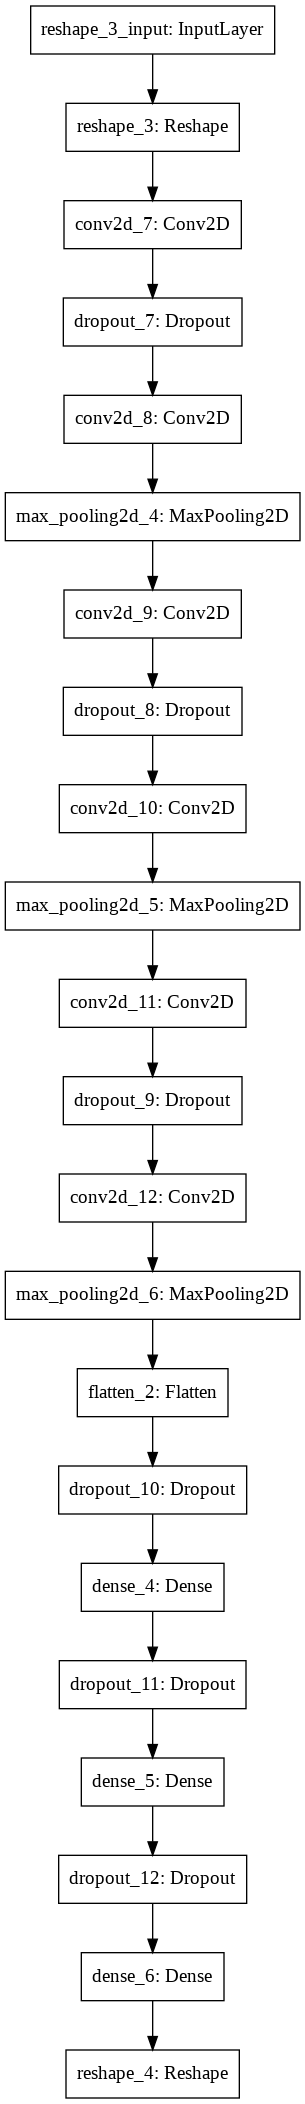

In [39]:

# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()

cnn_n.summary()

# Model printout (ascii)
sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True

# **Train DNN** and display results for various jpeg qualities given in jpeg_quality_list

 
 
Extrapolation factor =  0.5
JPEG compression =  97
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


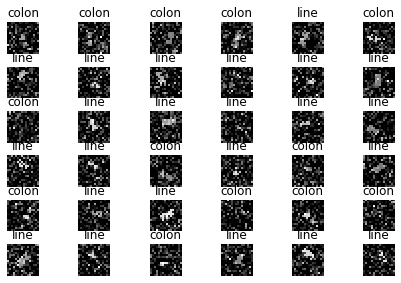

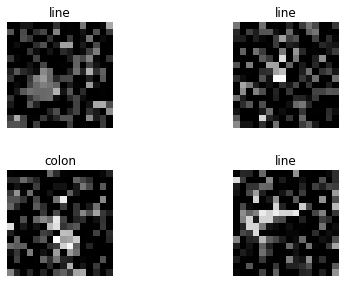

yy_train  (60000, 1, 2)
No saved model, training a new one.

Epoch 00001: val_categorical_accuracy improved from -inf to 0.73610, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.73610 to 0.74670, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.74670

Epoch 00004: val_categorical_accuracy improved from 0.74670 to 0.75510, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.75510

Epoch 00006: val_categorical_accuracy did not improve from 0.75510

Epoch 00007: val_categorical_accuracy improved from 0.75510 to 0.75690, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy improved from 0.75690 to 0.75950, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy improved from 0.75950 to 0.76860, saving model to best_model.h5

Epoch 00010: val_categorical_accuracy did not improve from 0.76860

Epoch 00011: val_categorical_accuracy improved from 

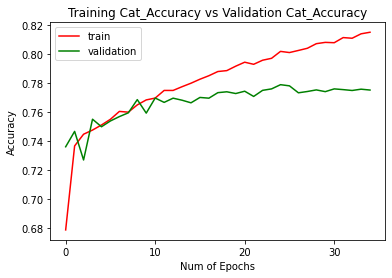

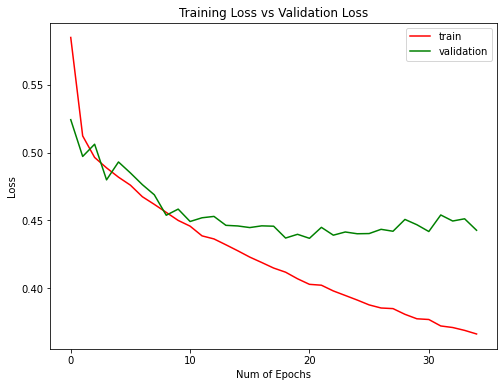

[[4129  894]
 [1362 3615]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


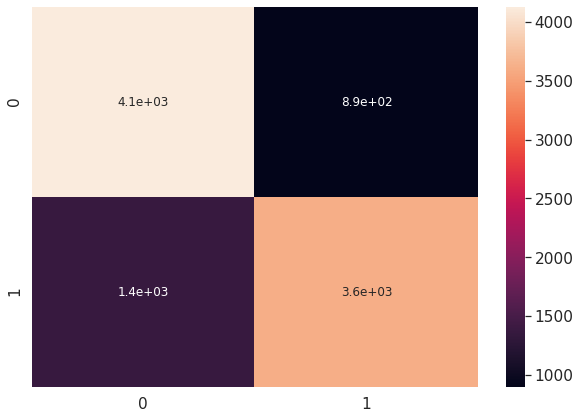

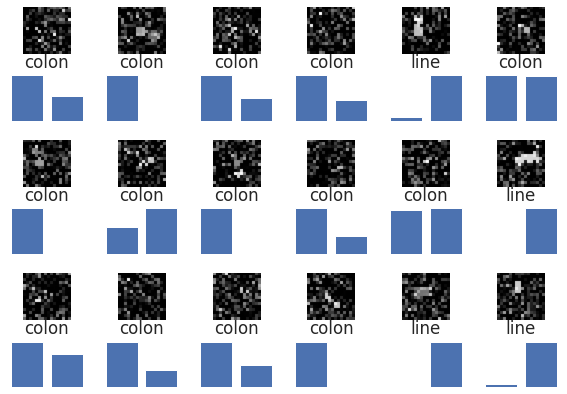

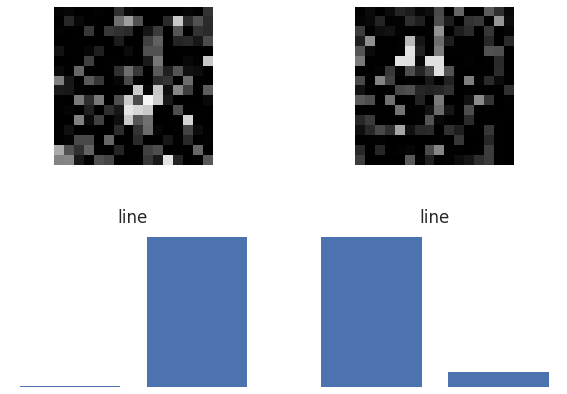

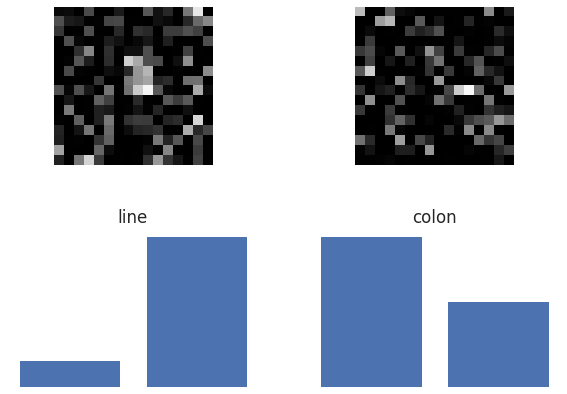

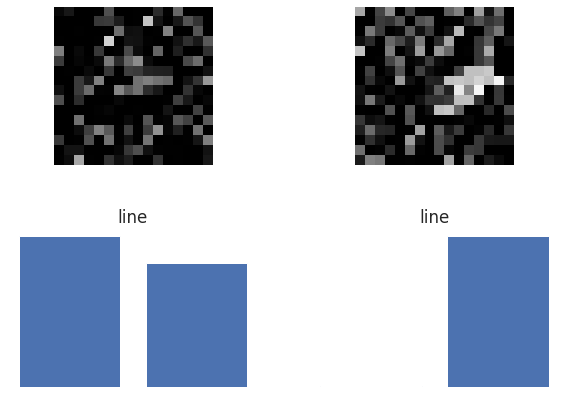

 
 
Extrapolation factor =  0.5
JPEG compression =  80
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


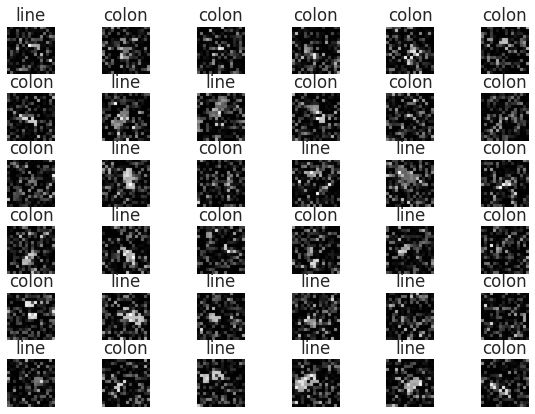

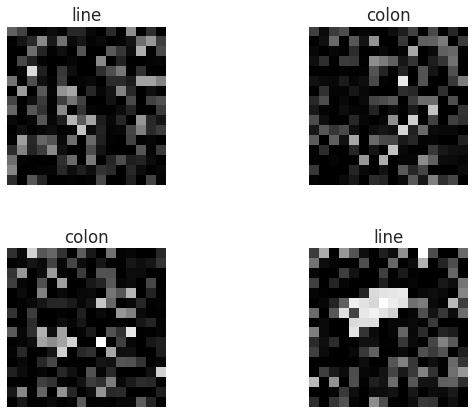

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.76580, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.76580

Epoch 00003: val_categorical_accuracy improved from 0.76580 to 0.77330, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.77330

Epoch 00005: val_categorical_accuracy did not improve from 0.77330

Epoch 00006: val_categorical_accuracy did not improve from 0.77330

Epoch 00007: val_categorical_accuracy did not improve from 0.77330

Epoch 00008: val_categorical_accuracy did not improve from 0.77330

Epoch 00009: val_categorical_accuracy did not improve from 0.77330

Epoch 00010: val_categorical_accuracy did not improve from 0.77330

Epoch 00011: val_categorical_accuracy improved from 0.77330 to 0.77680, saving model to best_model.h5

Epoch 00012: val_categorical_accuracy did not improve from 0.77680

Epoch 00013: val_categorical_accuracy did not improve fro

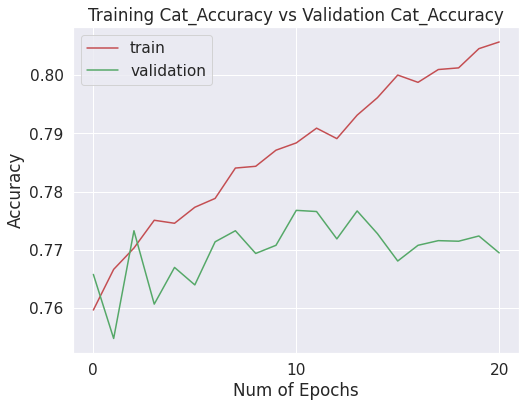

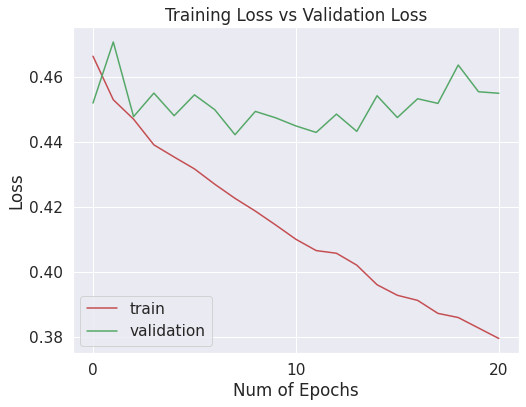

[[4085  881]
 [1344 3690]]


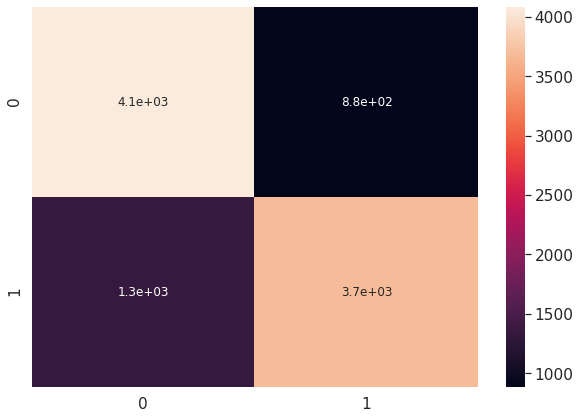

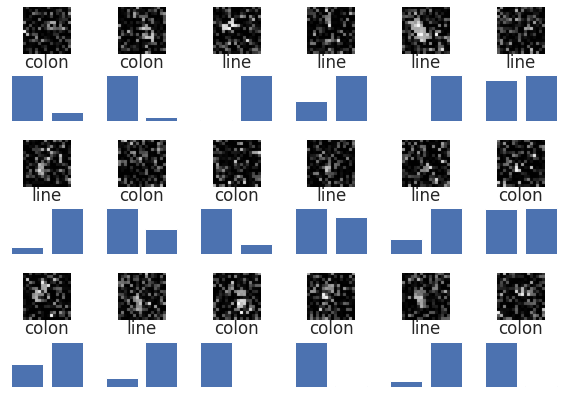

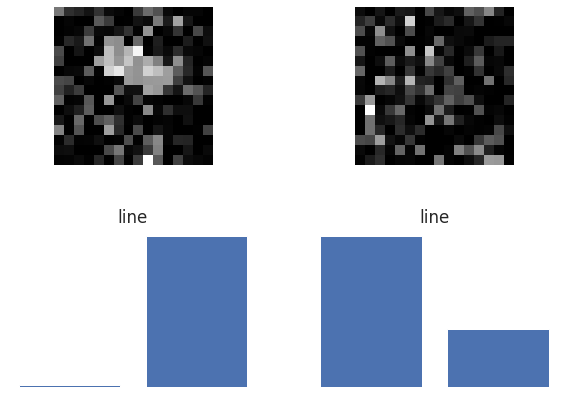

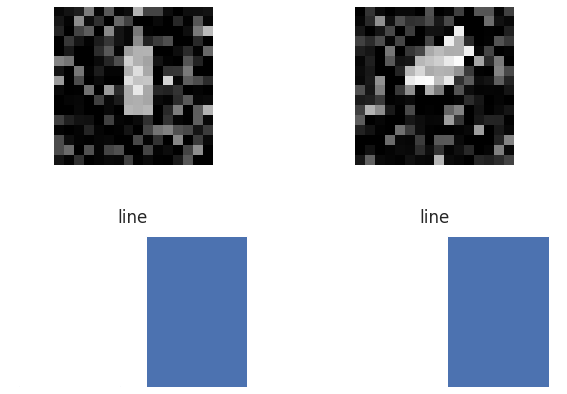

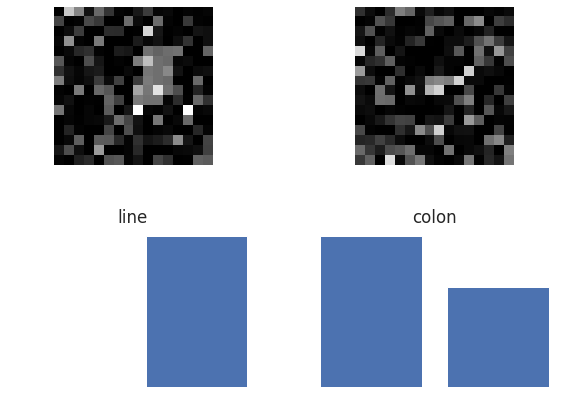

 
 
Extrapolation factor =  0.5
JPEG compression =  32
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


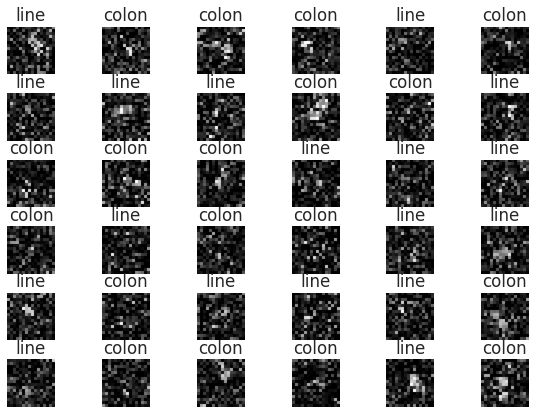

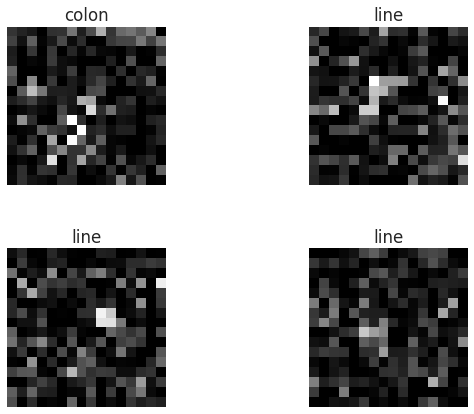

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.76150, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.76150

Epoch 00003: val_categorical_accuracy improved from 0.76150 to 0.76200, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.76200

Epoch 00005: val_categorical_accuracy did not improve from 0.76200

Epoch 00006: val_categorical_accuracy did not improve from 0.76200

Epoch 00007: val_categorical_accuracy did not improve from 0.76200

Epoch 00008: val_categorical_accuracy did not improve from 0.76200

Epoch 00009: val_categorical_accuracy did not improve from 0.76200

Epoch 00010: val_categorical_accuracy did not improve from 0.76200

Epoch 00011: val_categorical_accuracy did not improve from 0.76200

Epoch 00012: val_categorical_accuracy did not improve from 0.76200

Epoch 00013: val_categorical_accuracy did not improve from 0.76200
Epoch 00013: early stoppi

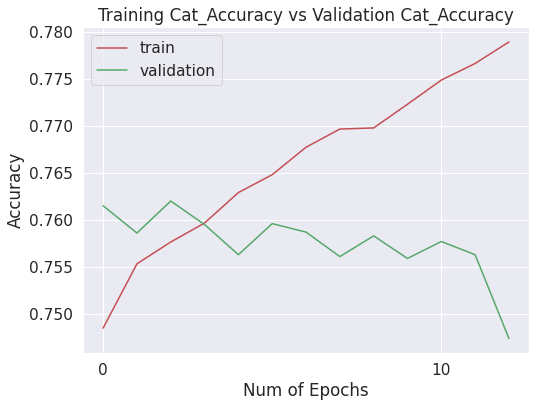

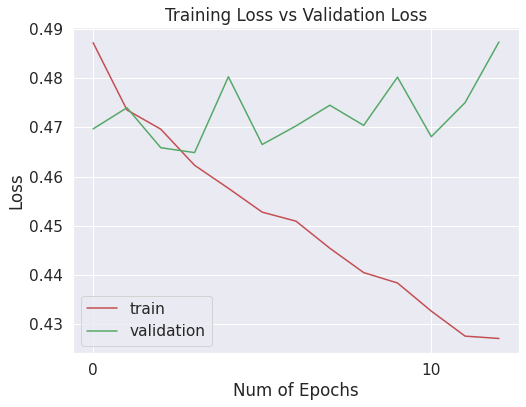

[[3935  964]
 [1488 3613]]


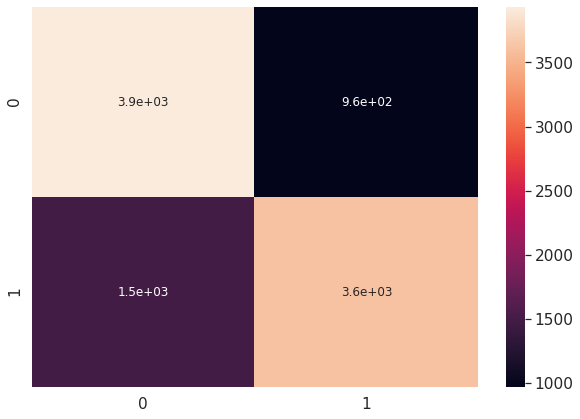

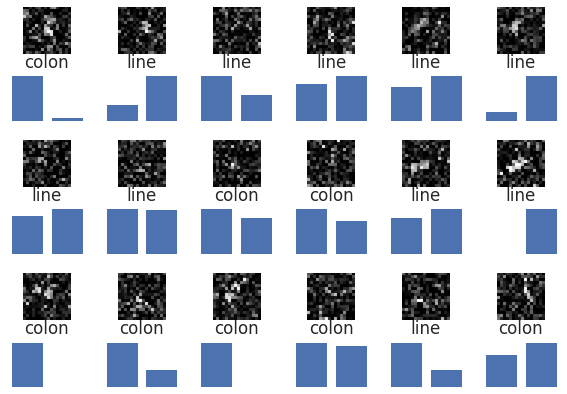

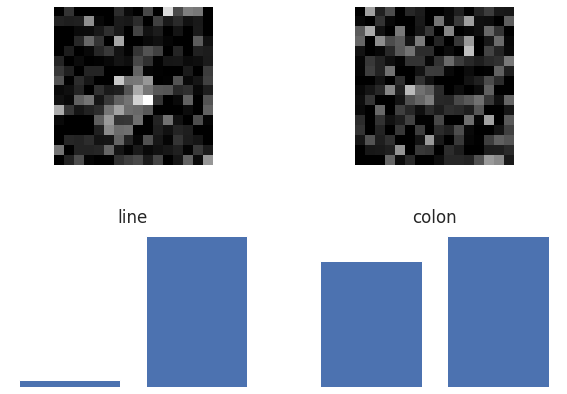

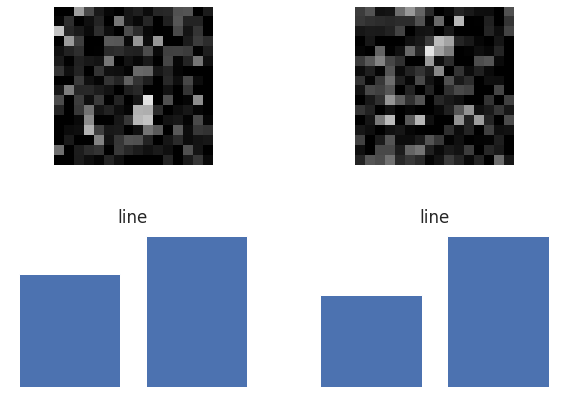

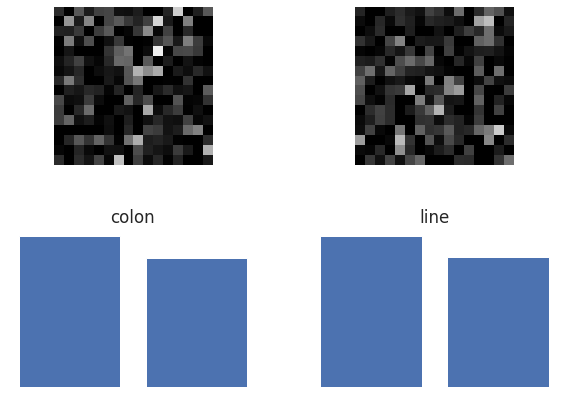

 
 
Extrapolation factor =  0.5
JPEG compression =  15
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


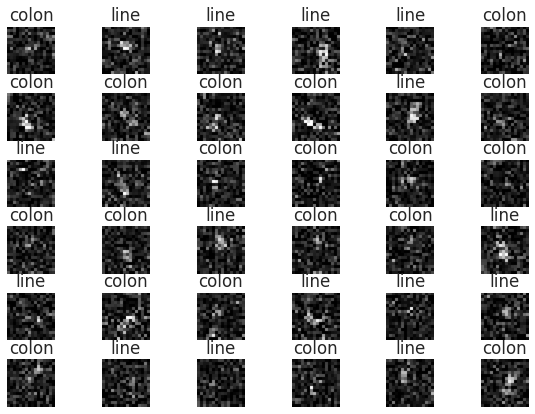

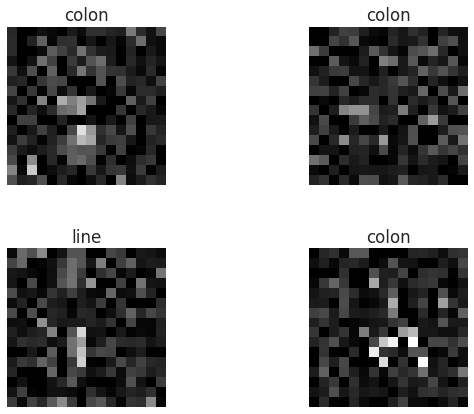

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.77670, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.77670 to 0.77850, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.77850

Epoch 00004: val_categorical_accuracy improved from 0.77850 to 0.77990, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.77990

Epoch 00006: val_categorical_accuracy improved from 0.77990 to 0.78020, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy improved from 0.78020 to 0.78330, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.78330

Epoch 00009: val_categorical_accuracy did not improve from 0.78330

Epoch 00010: val_categorical_accuracy did not improve from 0.78330

Epoch 00011: val_categorical_accuracy did not improve from 0.78330

Epoch 00012: val_categorical_accuracy did not improve f

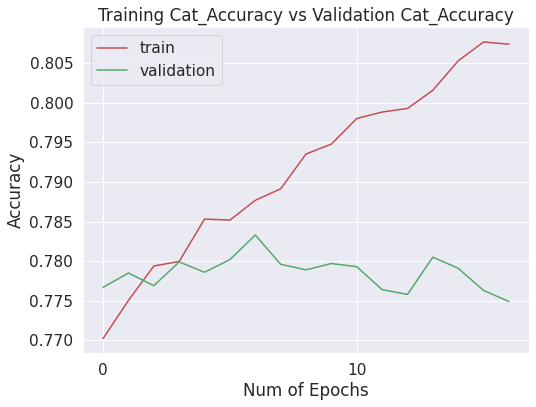

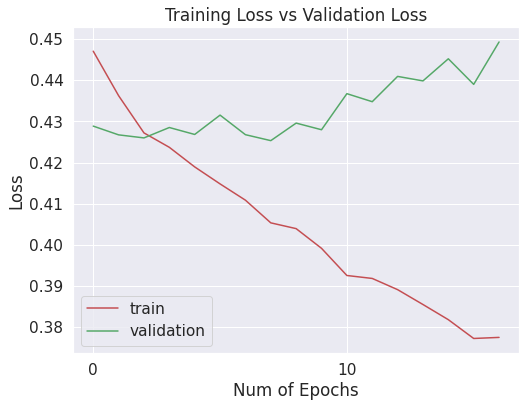

[[3849 1096]
 [1073 3982]]


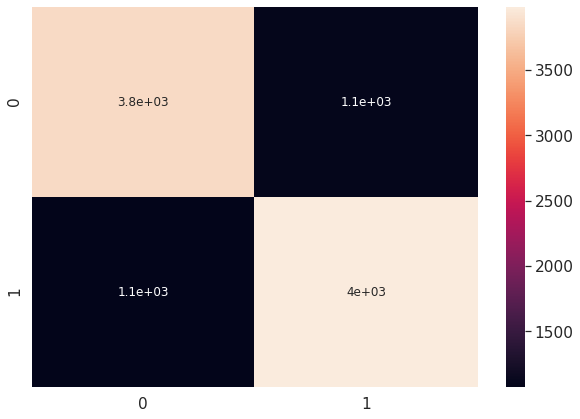

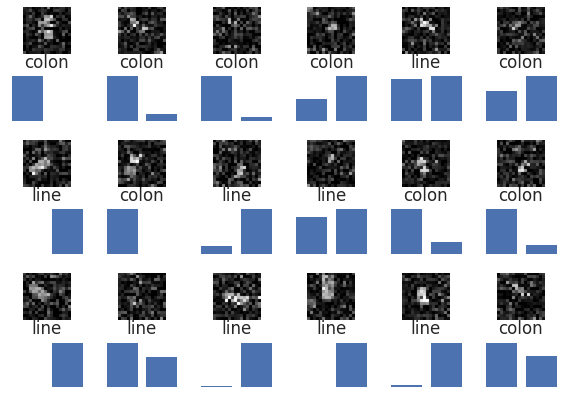

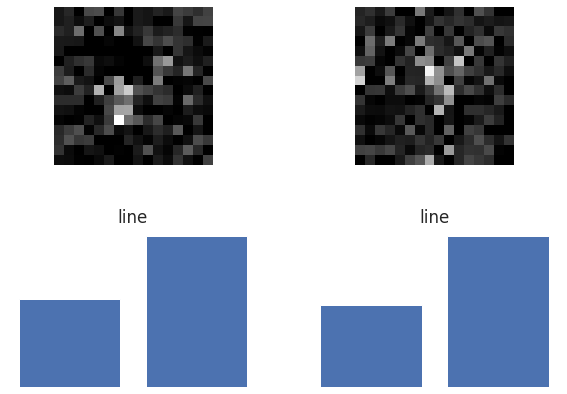

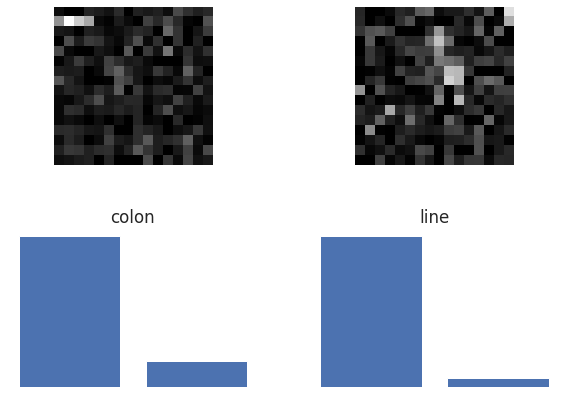

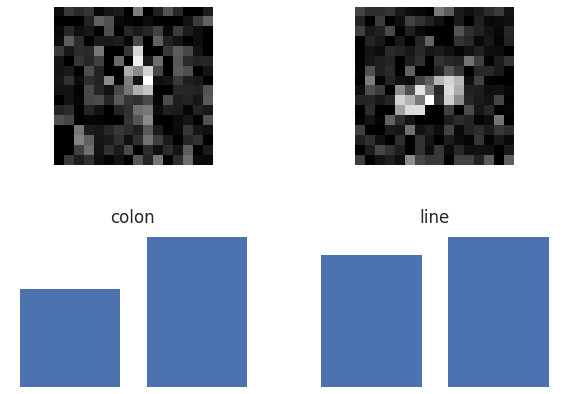

 
 
Extrapolation factor =  0.5
JPEG compression =  7
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


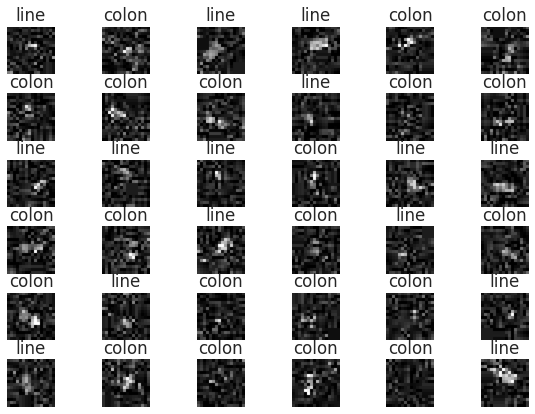

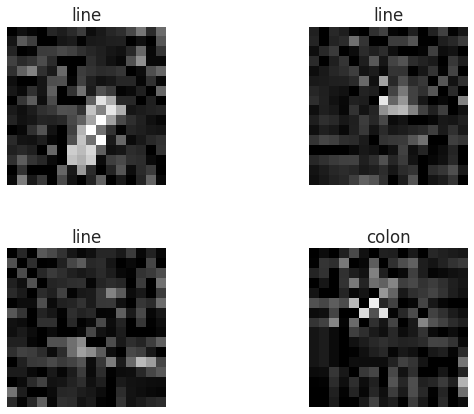

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.78700, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.78700

Epoch 00003: val_categorical_accuracy improved from 0.78700 to 0.79050, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.79050

Epoch 00005: val_categorical_accuracy improved from 0.79050 to 0.79120, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.79120

Epoch 00007: val_categorical_accuracy did not improve from 0.79120

Epoch 00008: val_categorical_accuracy did not improve from 0.79120

Epoch 00009: val_categorical_accuracy did not improve from 0.79120

Epoch 00010: val_categorical_accuracy improved from 0.79120 to 0.79150, saving model to best_model.h5

Epoch 00011: val_categorical_accuracy did not improve from 0.79150

Epoch 00012: val_categorical_accuracy did not improve from 0.79150

Epoch 00013: val_categ

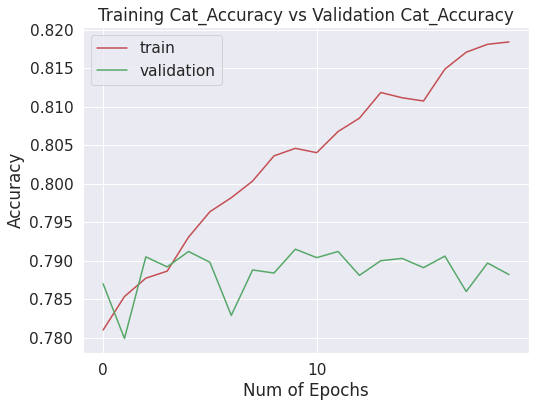

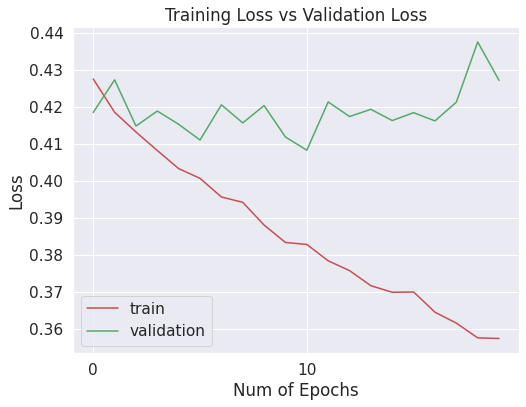

[[3960 1025]
 [1075 3940]]


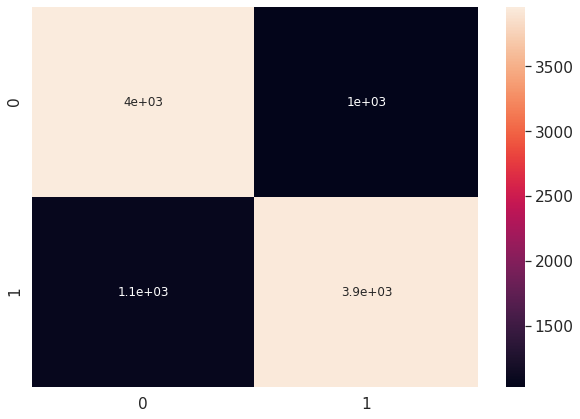

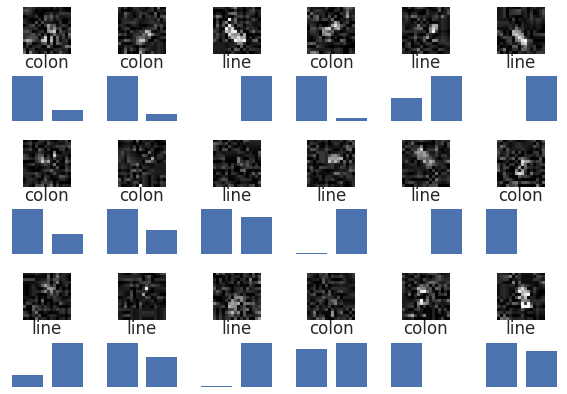

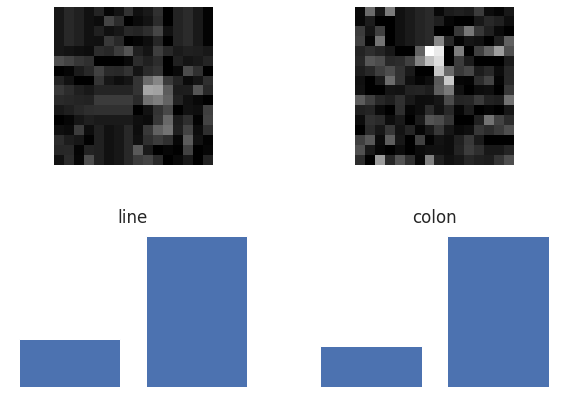

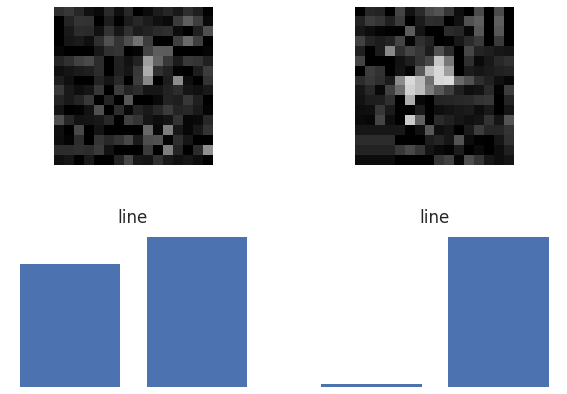

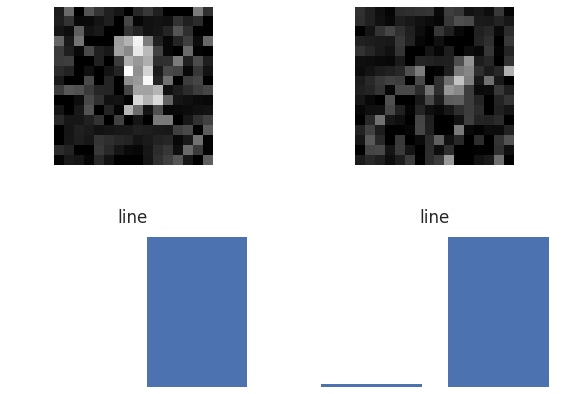

 
 
Extrapolation factor =  0.5
JPEG compression =  3
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


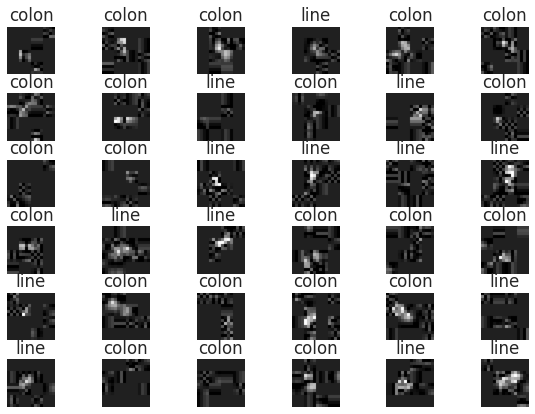

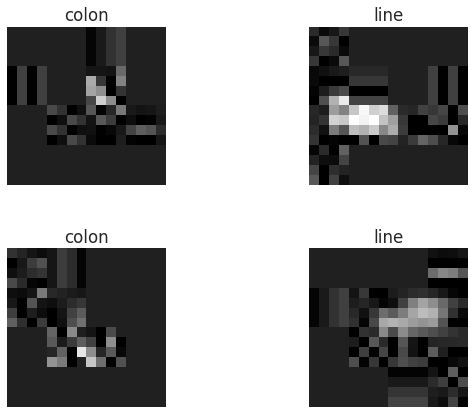

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.76400, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.76400

Epoch 00003: val_categorical_accuracy did not improve from 0.76400

Epoch 00004: val_categorical_accuracy did not improve from 0.76400

Epoch 00005: val_categorical_accuracy did not improve from 0.76400

Epoch 00006: val_categorical_accuracy did not improve from 0.76400

Epoch 00007: val_categorical_accuracy did not improve from 0.76400

Epoch 00008: val_categorical_accuracy did not improve from 0.76400

Epoch 00009: val_categorical_accuracy did not improve from 0.76400

Epoch 00010: val_categorical_accuracy improved from 0.76400 to 0.76480, saving model to best_model.h5

Epoch 00011: val_categorical_accuracy did not improve from 0.76480

Epoch 00012: val_categorical_accuracy did not improve from 0.76480

Epoch 00013: val_categorical_accuracy did not improve from 0.76480

Epoch 00014: val_categor

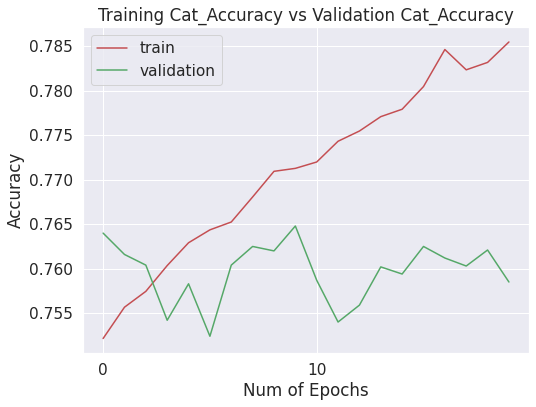

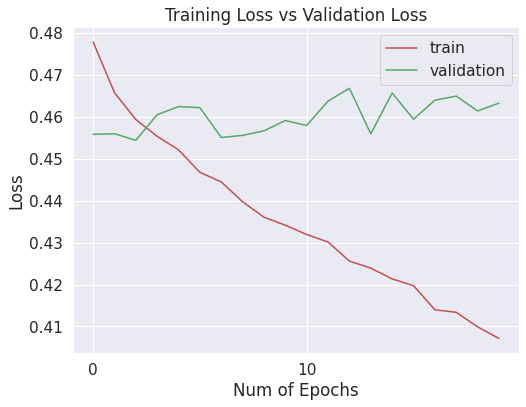

[[3952 1003]
 [1455 3590]]


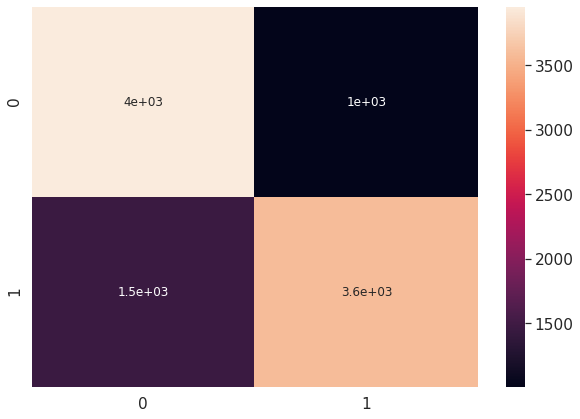

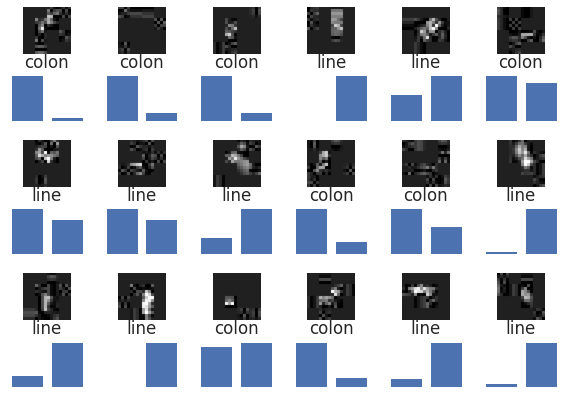

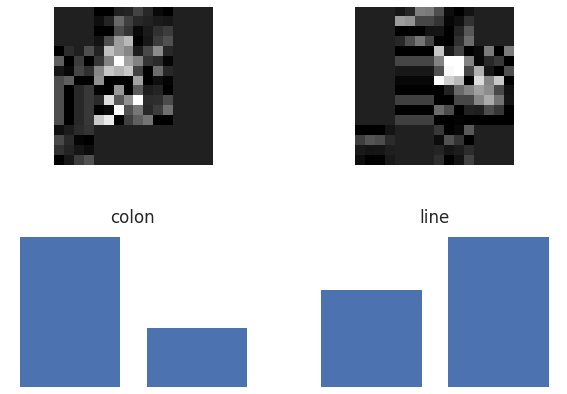

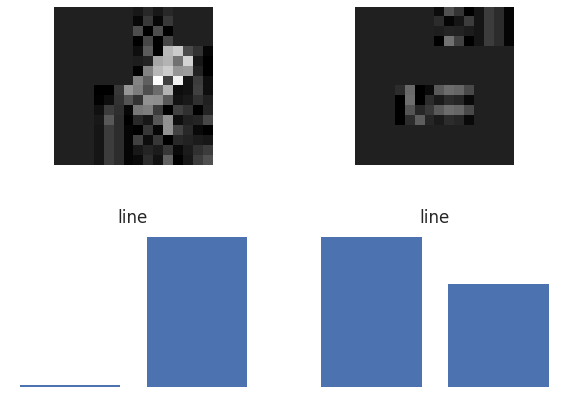

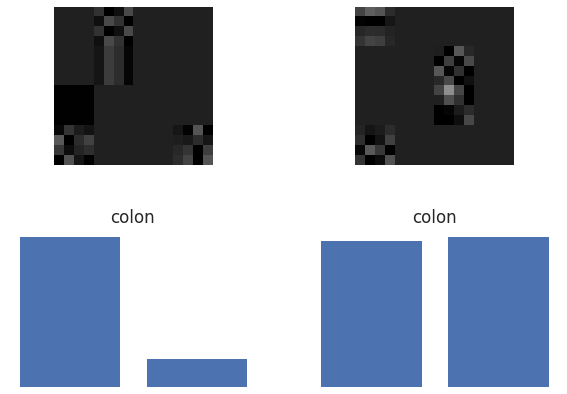

 
 
Extrapolation factor =  1.0
JPEG compression =  97
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


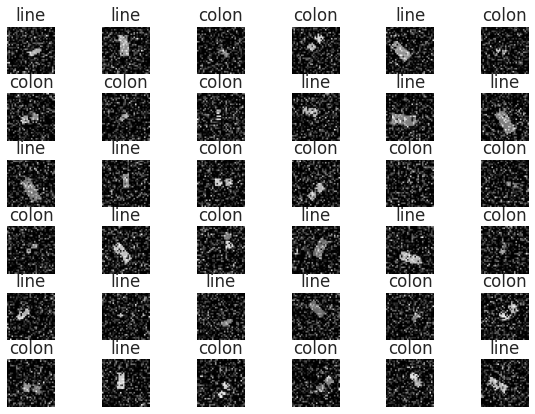

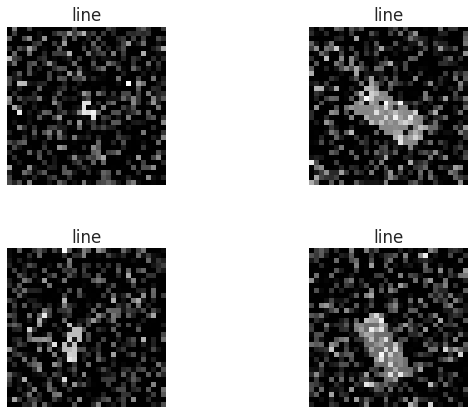

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.87430, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.87430 to 0.87990, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.87990

Epoch 00004: val_categorical_accuracy improved from 0.87990 to 0.88450, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.88450

Epoch 00006: val_categorical_accuracy improved from 0.88450 to 0.88780, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy did not improve from 0.88780

Epoch 00008: val_categorical_accuracy did not improve from 0.88780

Epoch 00009: val_categorical_accuracy improved from 0.88780 to 0.89020, saving model to best_model.h5

Epoch 00010: val_categorical_accuracy improved from 0.89020 to 0.89140, saving model to best_model.h5

Epoch 00011: val_categorical_accuracy did not improve from 0.89140

Epoch 00012: val_cat

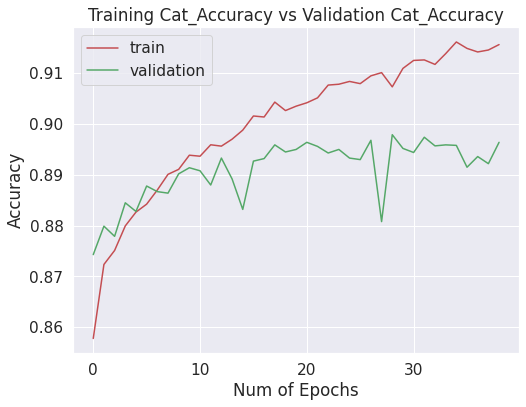

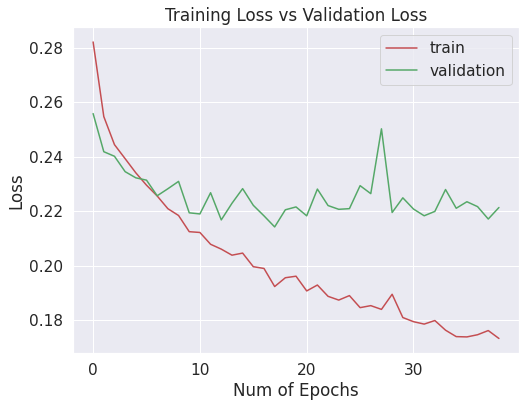

[[4314  608]
 [ 476 4602]]


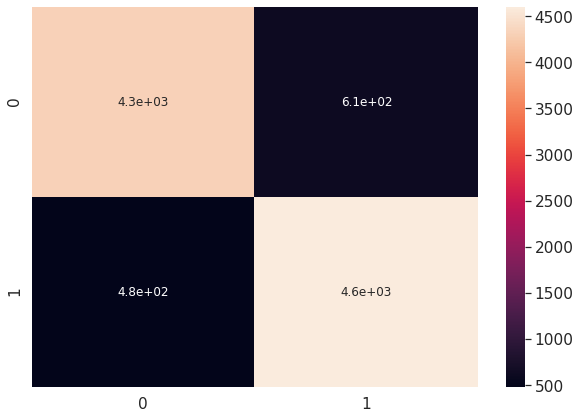

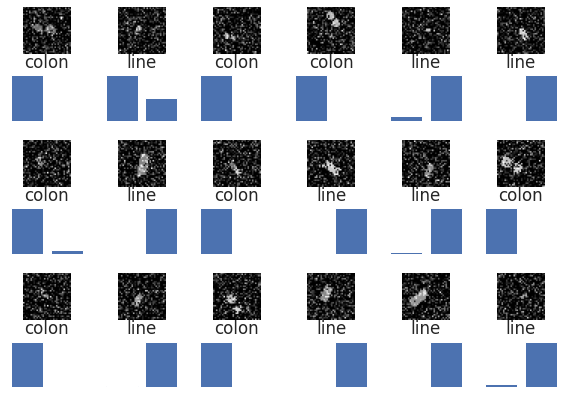

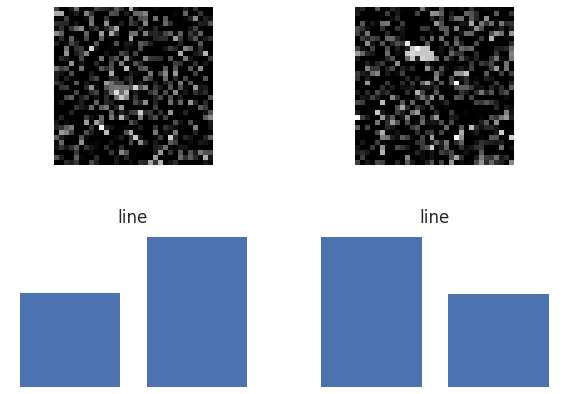

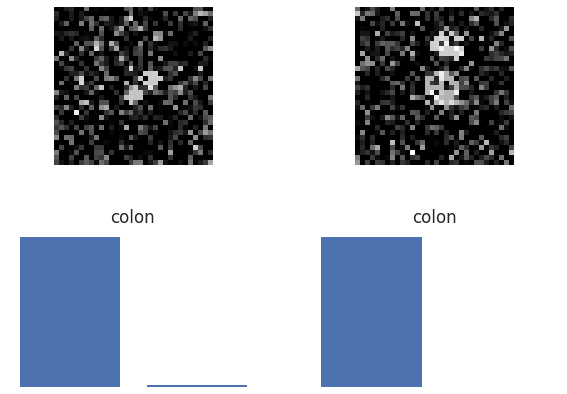

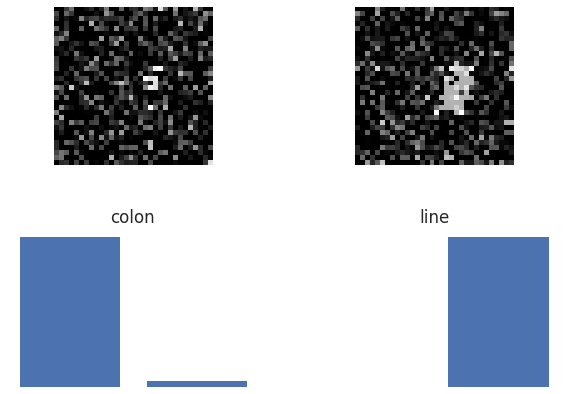

 
 
Extrapolation factor =  1.0
JPEG compression =  80
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


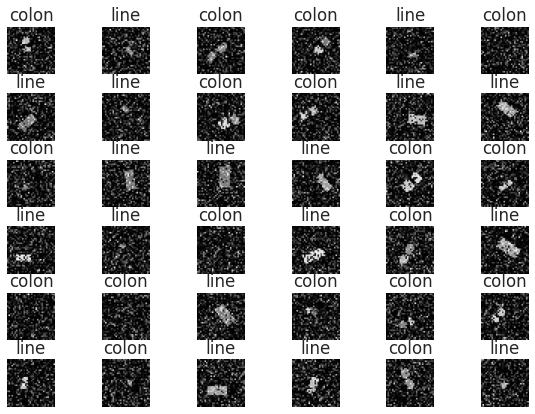

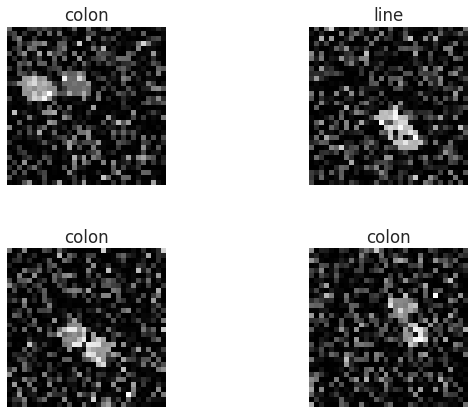

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.89930, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.89930

Epoch 00003: val_categorical_accuracy improved from 0.89930 to 0.90040, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.90040

Epoch 00005: val_categorical_accuracy did not improve from 0.90040

Epoch 00006: val_categorical_accuracy did not improve from 0.90040

Epoch 00007: val_categorical_accuracy improved from 0.90040 to 0.90100, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.90100

Epoch 00009: val_categorical_accuracy did not improve from 0.90100

Epoch 00010: val_categorical_accuracy did not improve from 0.90100

Epoch 00011: val_categorical_accuracy did not improve from 0.90100

Epoch 00012: val_categorical_accuracy improved from 0.90100 to 0.90150, saving model to best_model.h5

Epoch 00013: val_categ

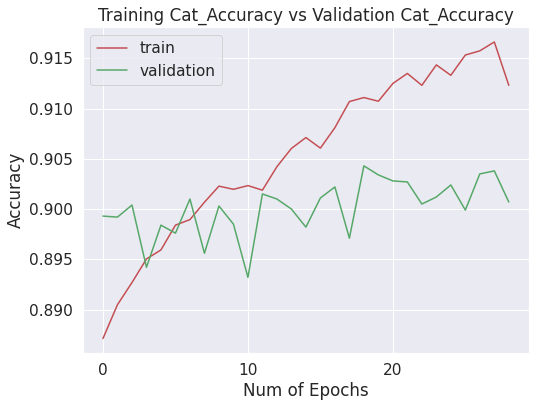

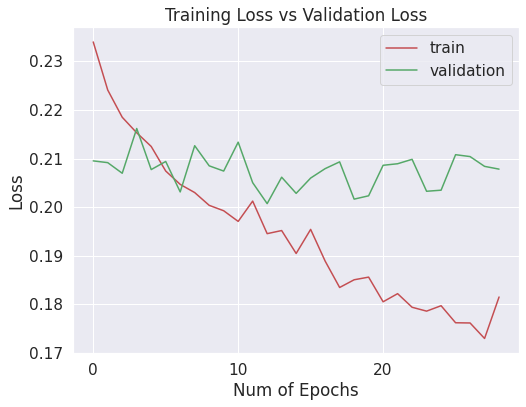

[[4464  589]
 [ 363 4584]]


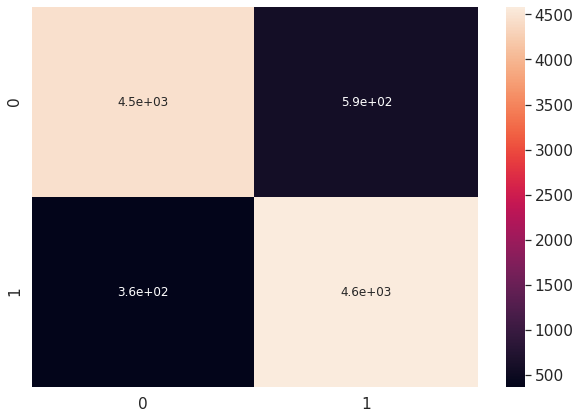

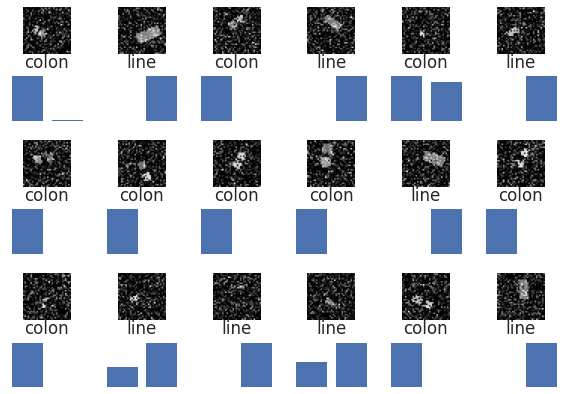

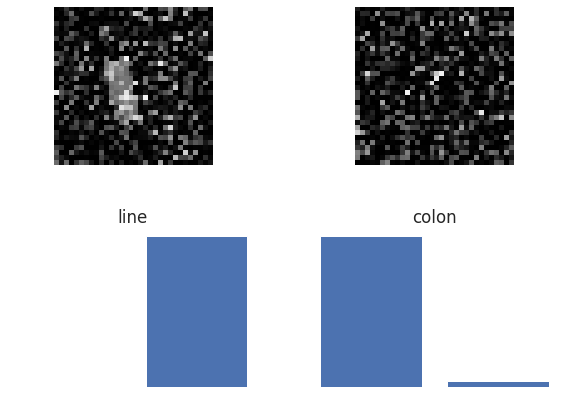

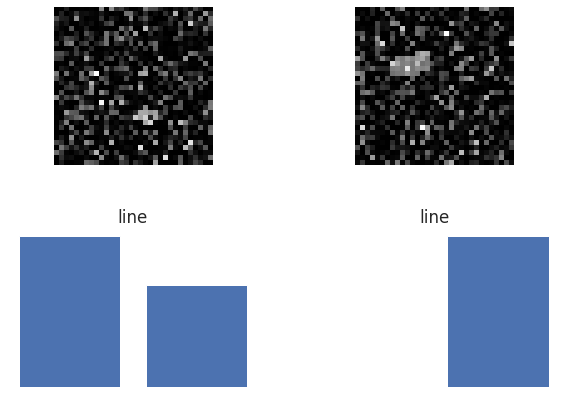

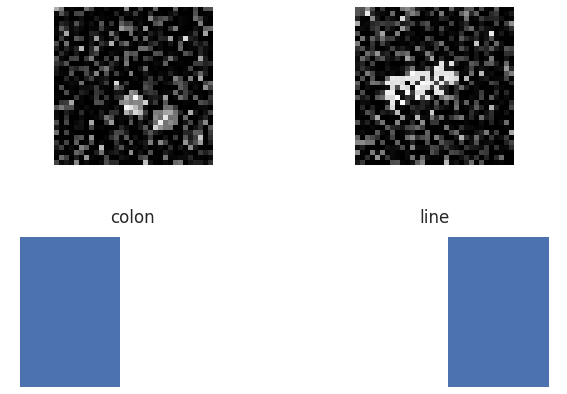

 
 
Extrapolation factor =  1.0
JPEG compression =  32
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


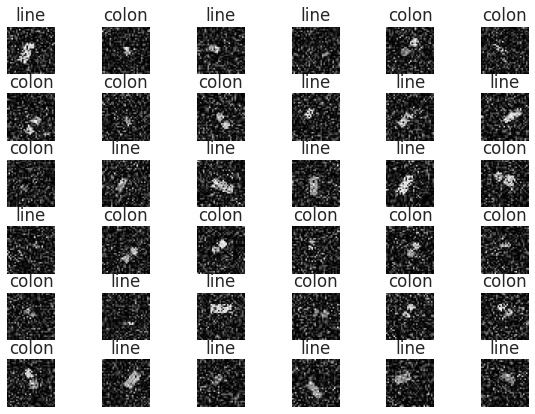

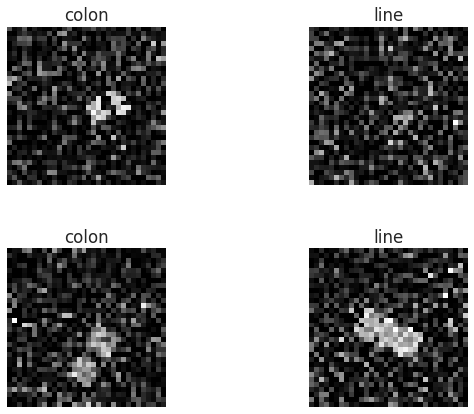

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.89250, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.89250 to 0.89670, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.89670

Epoch 00004: val_categorical_accuracy improved from 0.89670 to 0.89830, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.89830

Epoch 00006: val_categorical_accuracy did not improve from 0.89830

Epoch 00007: val_categorical_accuracy did not improve from 0.89830

Epoch 00008: val_categorical_accuracy did not improve from 0.89830

Epoch 00009: val_categorical_accuracy did not improve from 0.89830

Epoch 00010: val_categorical_accuracy did not improve from 0.89830

Epoch 00011: val_categorical_accuracy did not improve from 0.89830

Epoch 00012: val_categorical_accuracy did not improve from 0.89830

Epoch 00013: val_categorical_accuracy did not improve fro

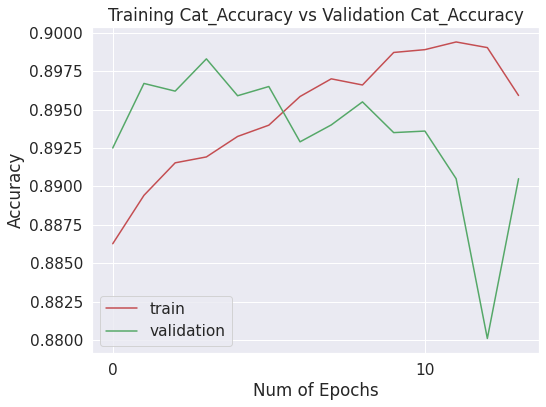

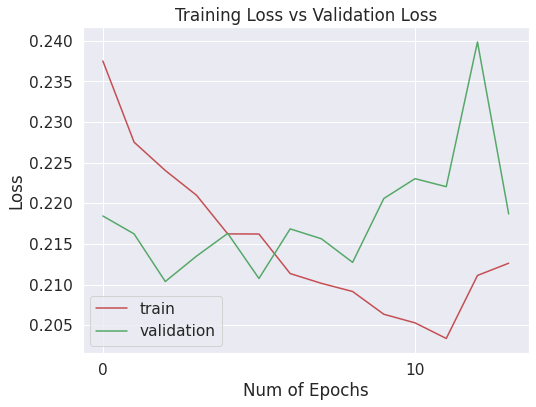

[[4296  722]
 [ 329 4653]]


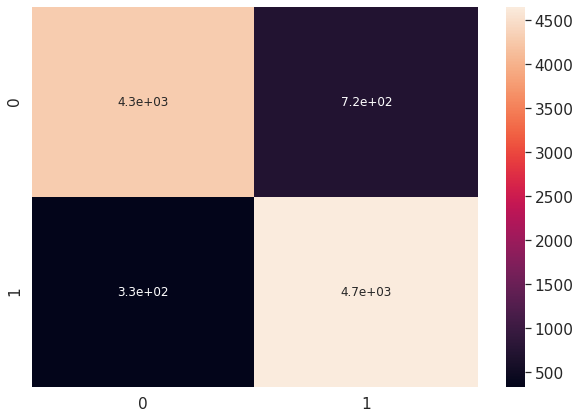

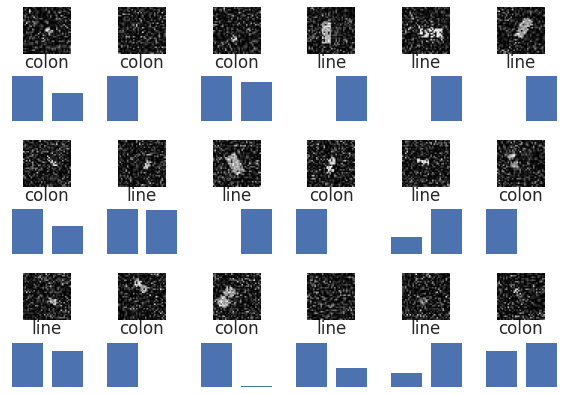

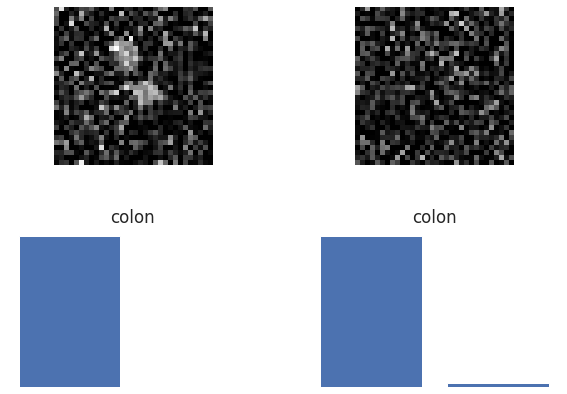

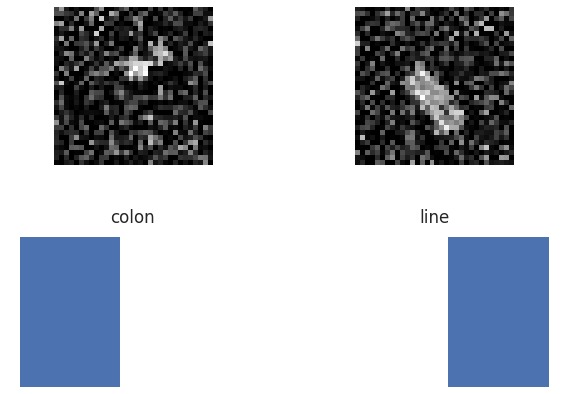

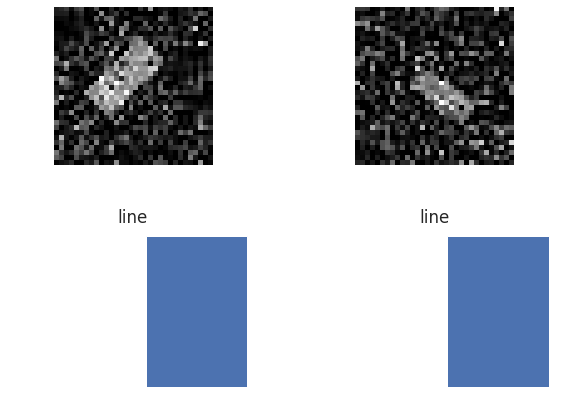

 
 
Extrapolation factor =  1.0
JPEG compression =  15
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


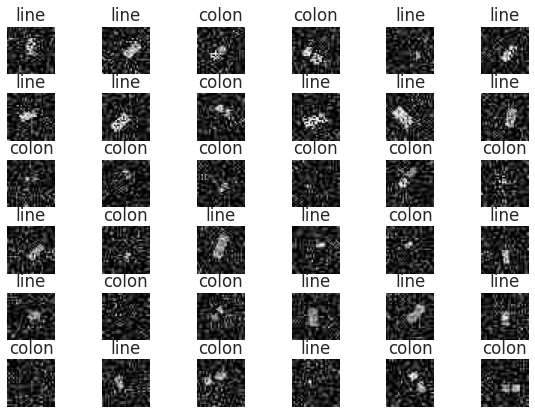

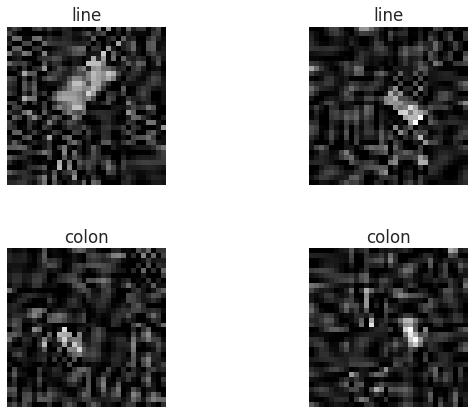

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.87950, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.87950 to 0.88020, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.88020

Epoch 00004: val_categorical_accuracy did not improve from 0.88020

Epoch 00005: val_categorical_accuracy did not improve from 0.88020

Epoch 00006: val_categorical_accuracy improved from 0.88020 to 0.88070, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy improved from 0.88070 to 0.88150, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.88150

Epoch 00009: val_categorical_accuracy did not improve from 0.88150

Epoch 00010: val_categorical_accuracy did not improve from 0.88150

Epoch 00011: val_categorical_accuracy did not improve from 0.88150

Epoch 00012: val_categorical_accuracy did not improve from 0.88150

Epoch 00013: val_categ

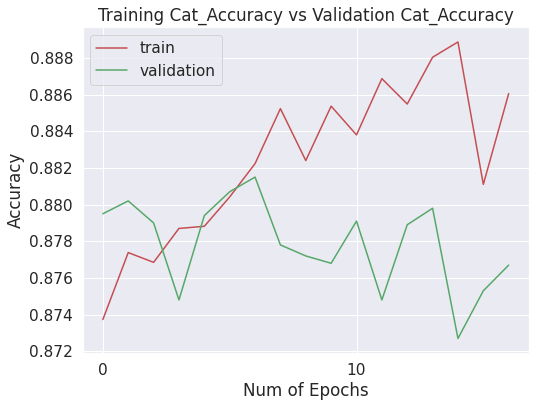

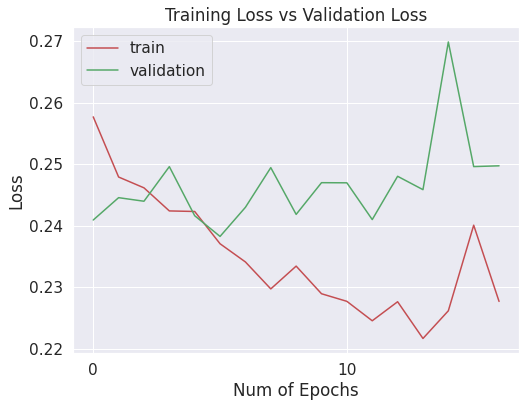

[[4369  702]
 [ 448 4481]]


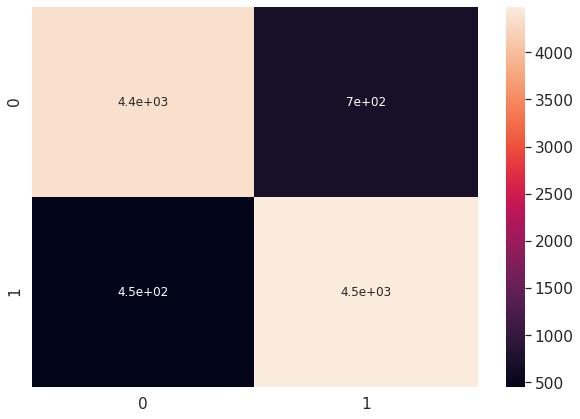

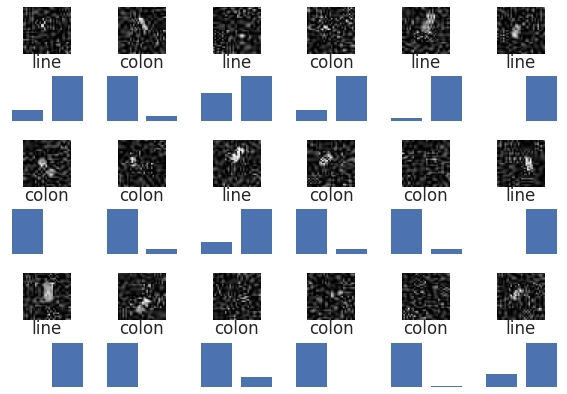

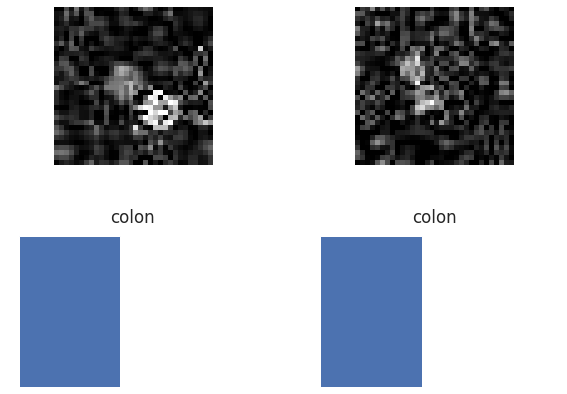

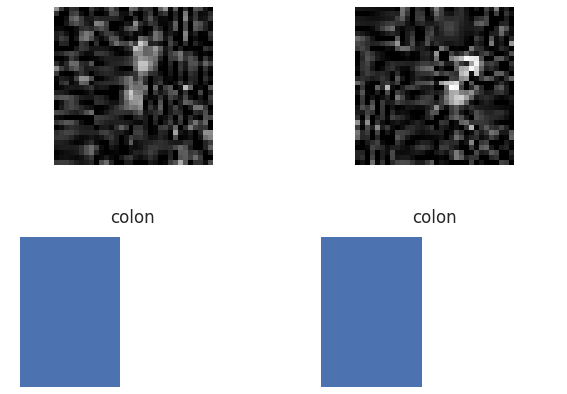

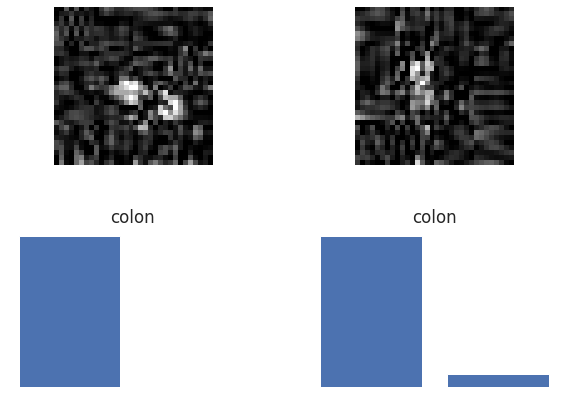

 
 
Extrapolation factor =  1.0
JPEG compression =  7
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


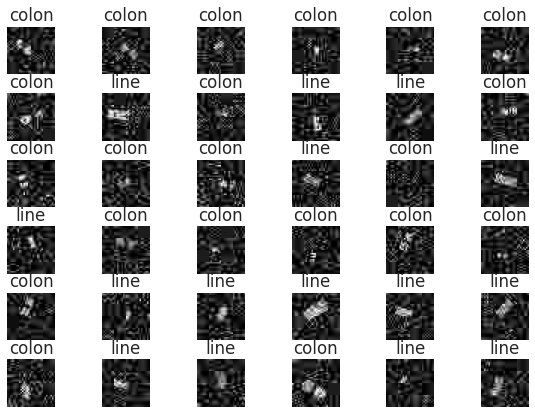

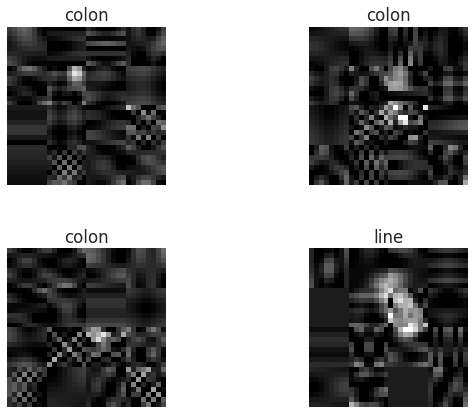

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.87160, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.87160

Epoch 00003: val_categorical_accuracy did not improve from 0.87160

Epoch 00004: val_categorical_accuracy did not improve from 0.87160

Epoch 00005: val_categorical_accuracy did not improve from 0.87160

Epoch 00006: val_categorical_accuracy did not improve from 0.87160

Epoch 00007: val_categorical_accuracy did not improve from 0.87160

Epoch 00008: val_categorical_accuracy did not improve from 0.87160

Epoch 00009: val_categorical_accuracy did not improve from 0.87160

Epoch 00010: val_categorical_accuracy did not improve from 0.87160

Epoch 00011: val_categorical_accuracy improved from 0.87160 to 0.87210, saving model to best_model.h5

Epoch 00012: val_categorical_accuracy did not improve from 0.87210

Epoch 00013: val_categorical_accuracy did not improve from 0.87210

Epoch 00014: val_categor

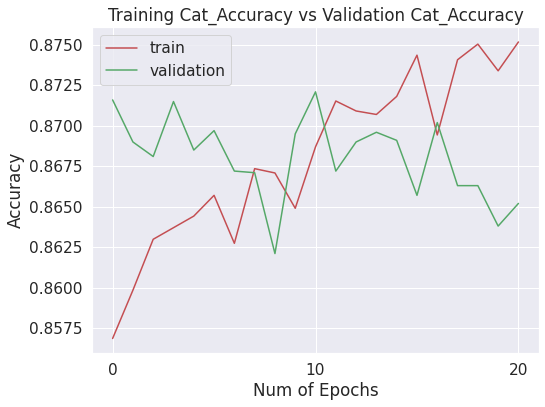

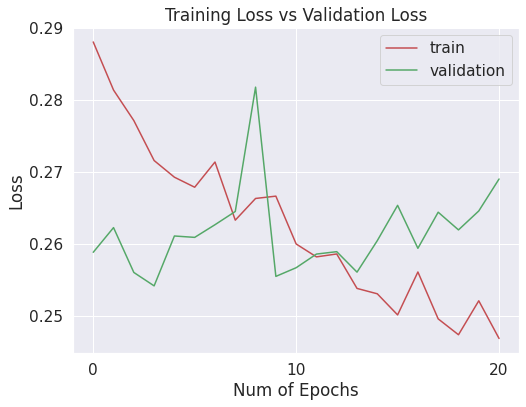

[[4268  741]
 [ 578 4413]]


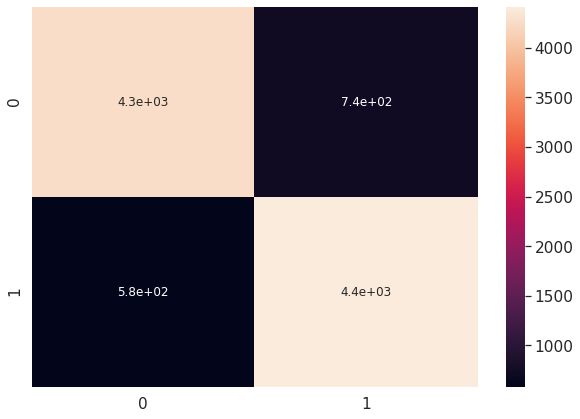

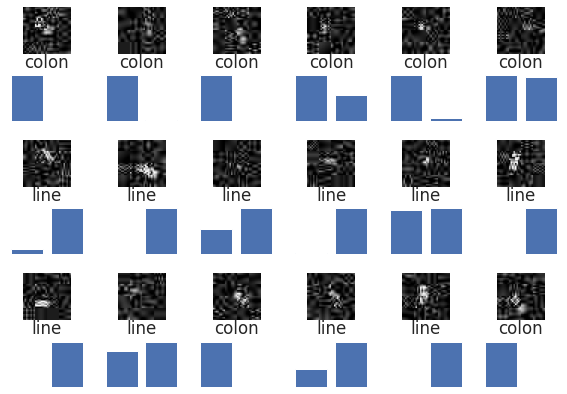

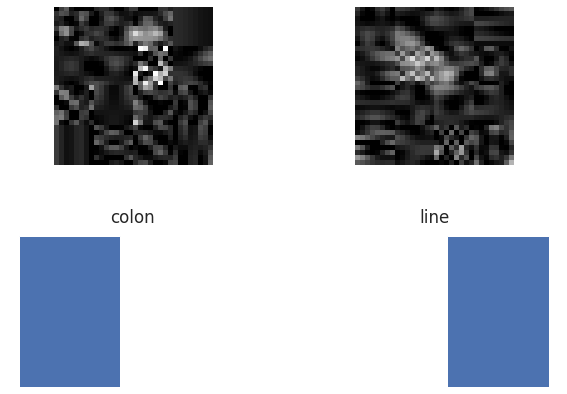

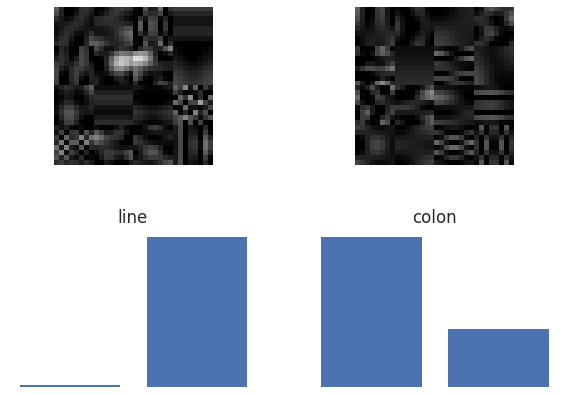

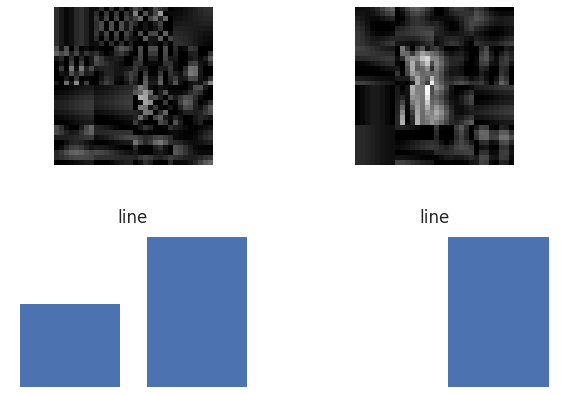

 
 
Extrapolation factor =  1.0
JPEG compression =  3
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


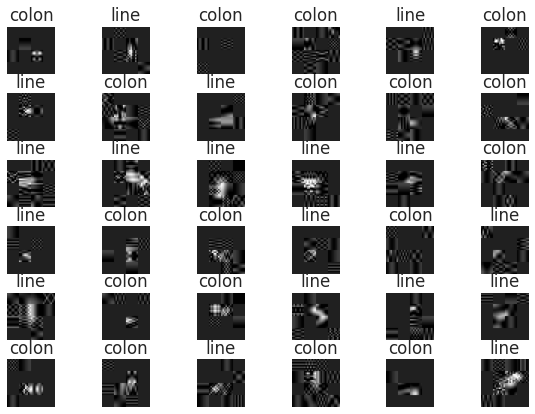

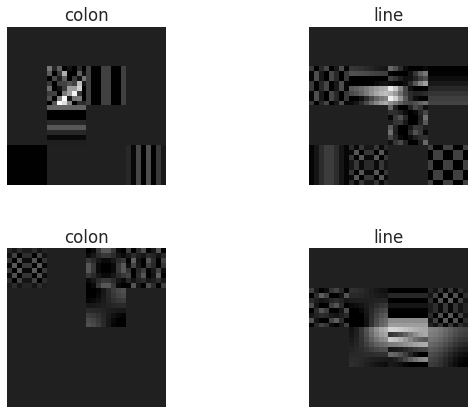

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.82200, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.82200

Epoch 00003: val_categorical_accuracy did not improve from 0.82200

Epoch 00004: val_categorical_accuracy did not improve from 0.82200

Epoch 00005: val_categorical_accuracy did not improve from 0.82200

Epoch 00006: val_categorical_accuracy did not improve from 0.82200

Epoch 00007: val_categorical_accuracy improved from 0.82200 to 0.82310, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.82310

Epoch 00009: val_categorical_accuracy did not improve from 0.82310

Epoch 00010: val_categorical_accuracy did not improve from 0.82310

Epoch 00011: val_categorical_accuracy did not improve from 0.82310

Epoch 00012: val_categorical_accuracy did not improve from 0.82310

Epoch 00013: val_categorical_accuracy did not improve from 0.82310

Epoch 00014: val_categor

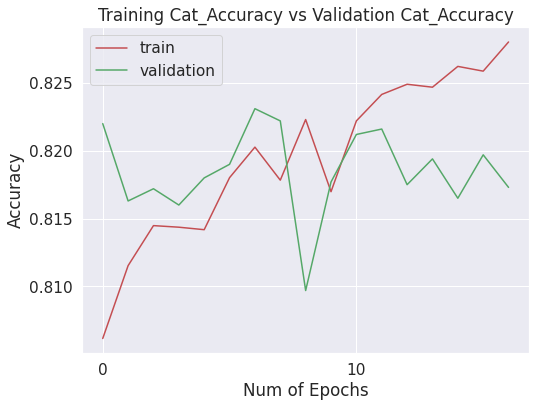

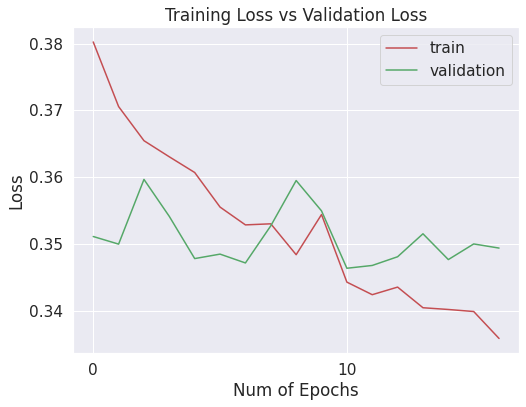

[[3855 1026]
 [ 735 4384]]


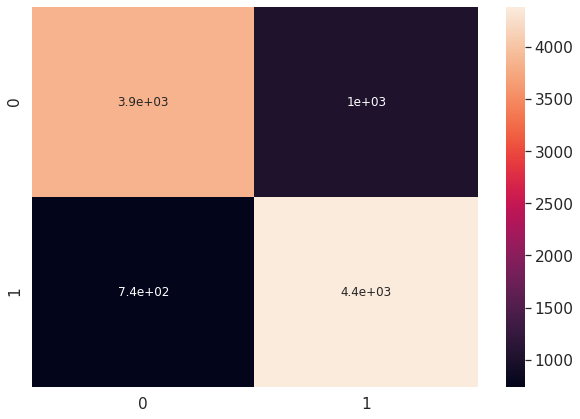

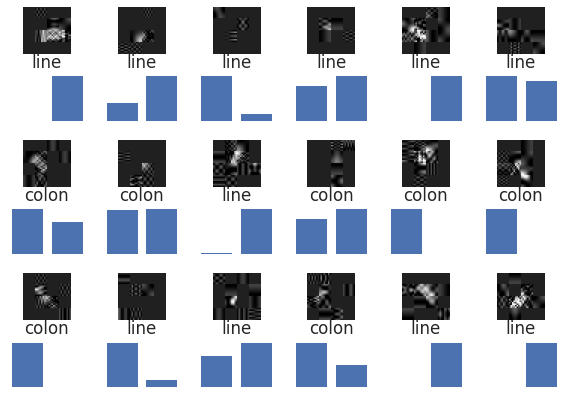

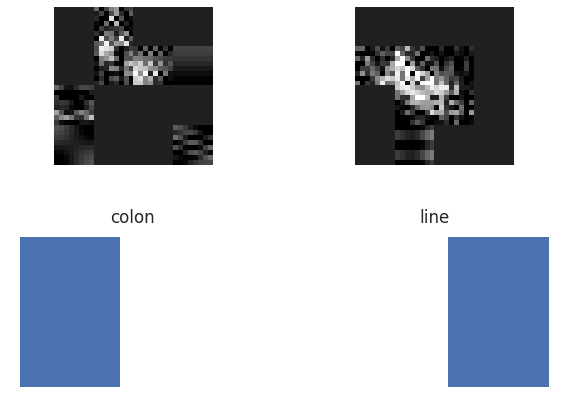

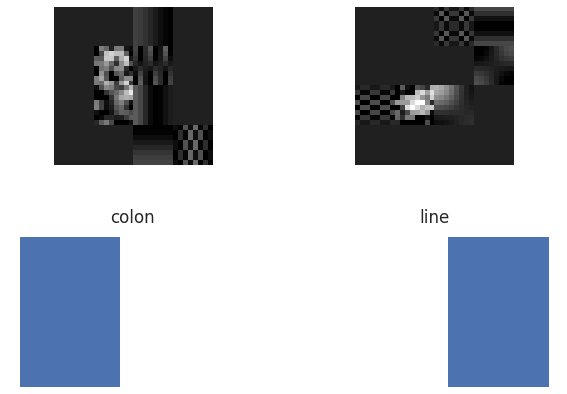

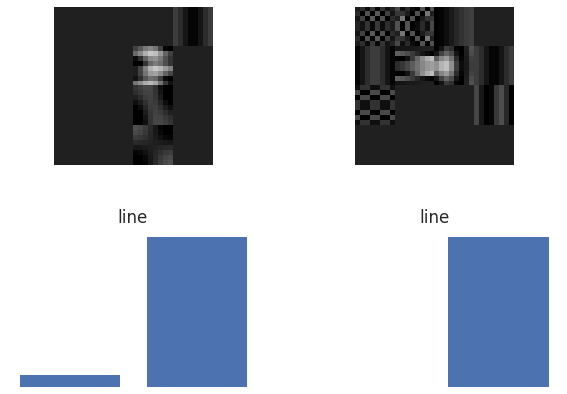

 
 
Extrapolation factor =  2.0
JPEG compression =  97
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


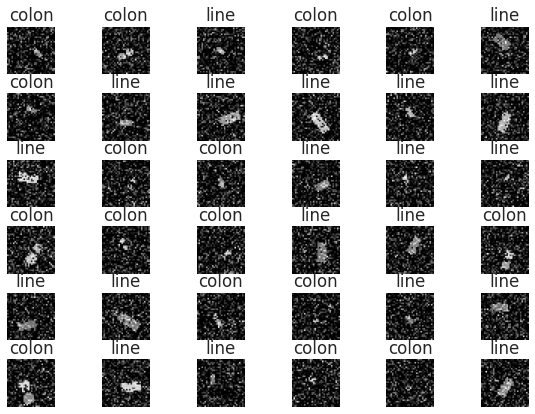

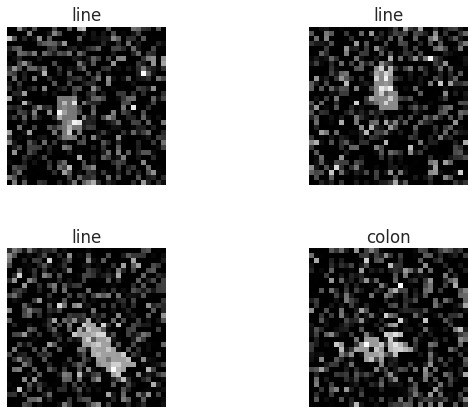

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88250, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.88250 to 0.89330, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.89330

Epoch 00004: val_categorical_accuracy improved from 0.89330 to 0.89880, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy improved from 0.89880 to 0.89960, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.89960

Epoch 00007: val_categorical_accuracy did not improve from 0.89960

Epoch 00008: val_categorical_accuracy improved from 0.89960 to 0.90420, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy did not improve from 0.90420

Epoch 00010: val_categorical_accuracy did not improve from 0.90420

Epoch 00011: val_categorical_accuracy did not improve from 0.90420

Epoch 00012: val_categorical_accuracy did not improve f

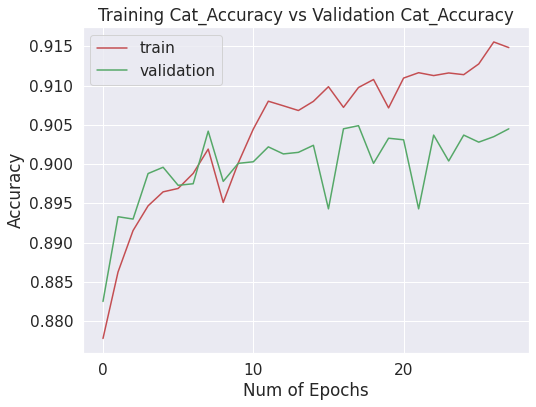

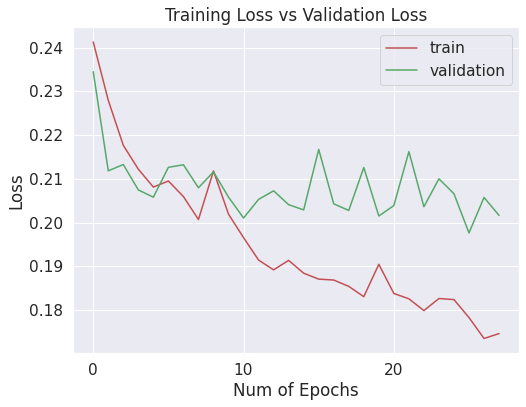

[[4465  561]
 [ 318 4656]]


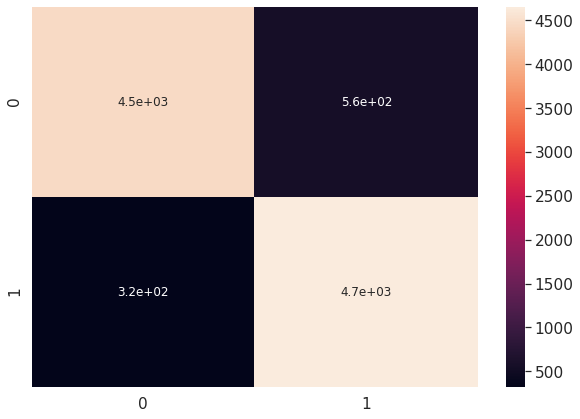

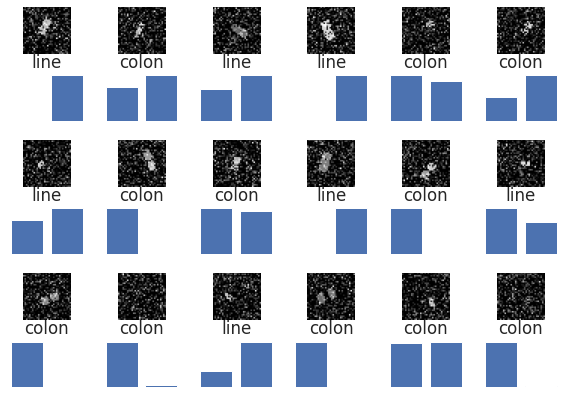

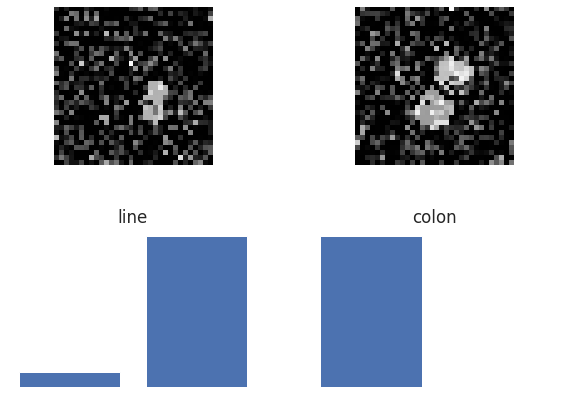

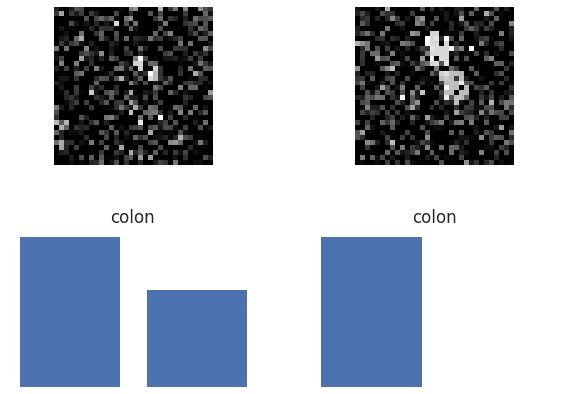

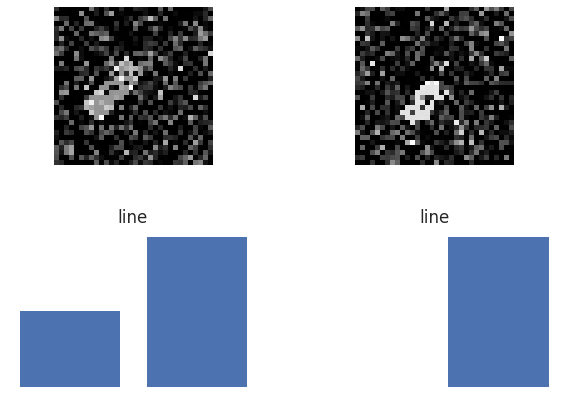

 
 
Extrapolation factor =  2.0
JPEG compression =  80
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


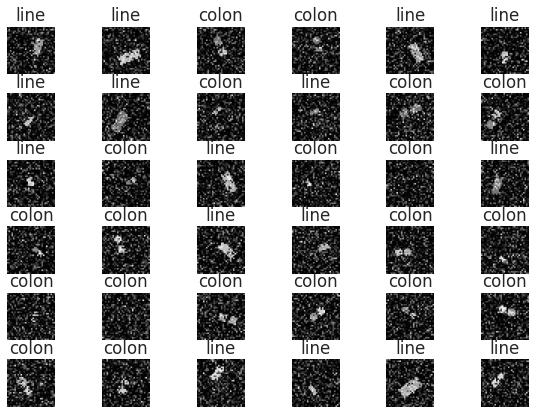

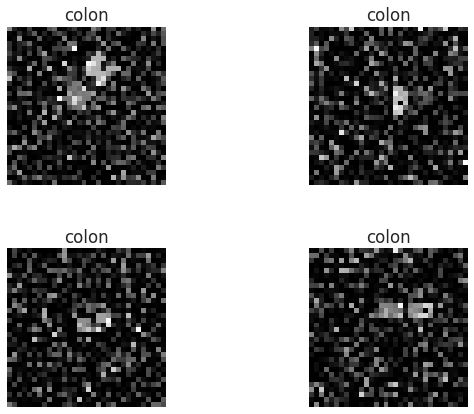

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.90550, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.90550

Epoch 00003: val_categorical_accuracy improved from 0.90550 to 0.90600, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy improved from 0.90600 to 0.90780, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.90780

Epoch 00006: val_categorical_accuracy did not improve from 0.90780

Epoch 00007: val_categorical_accuracy did not improve from 0.90780

Epoch 00008: val_categorical_accuracy did not improve from 0.90780

Epoch 00009: val_categorical_accuracy improved from 0.90780 to 0.91060, saving model to best_model.h5

Epoch 00010: val_categorical_accuracy did not improve from 0.91060

Epoch 00011: val_categorical_accuracy did not improve from 0.91060

Epoch 00012: val_categorical_accuracy did not improve from 0.91060

Epoch 00013: val_categ

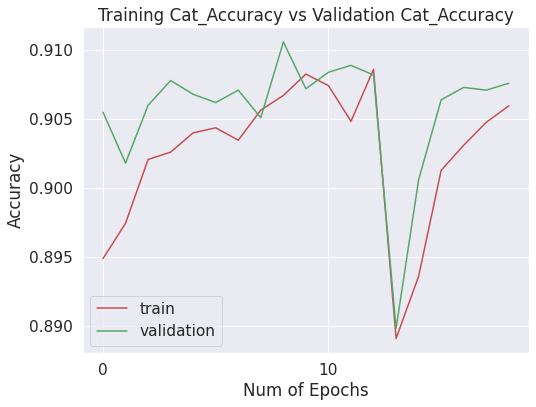

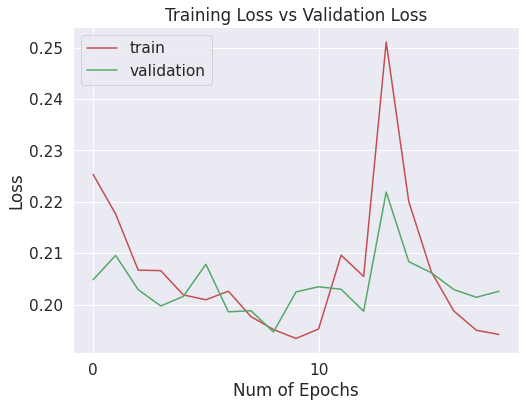

[[4331  667]
 [ 243 4759]]


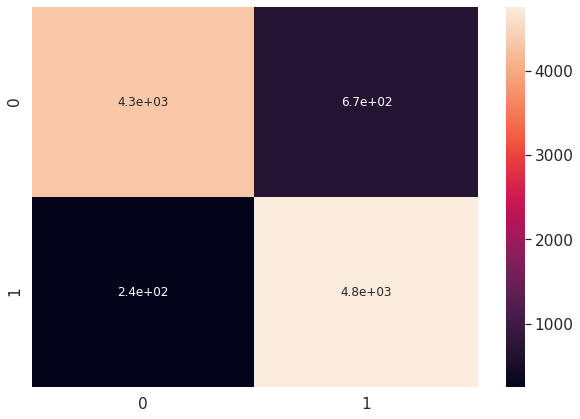

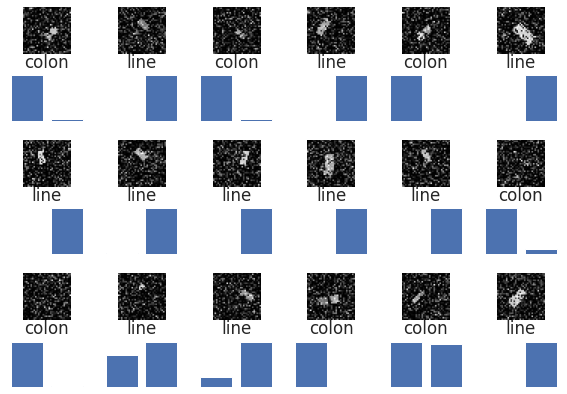

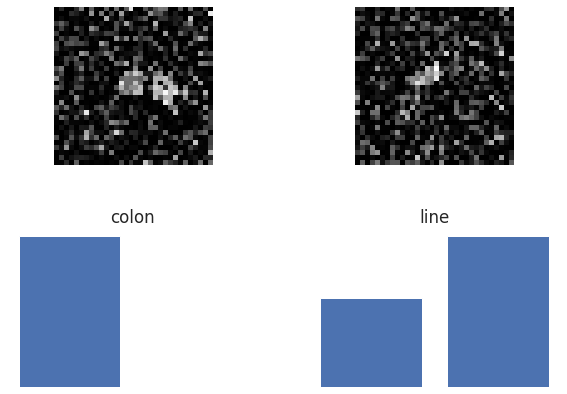

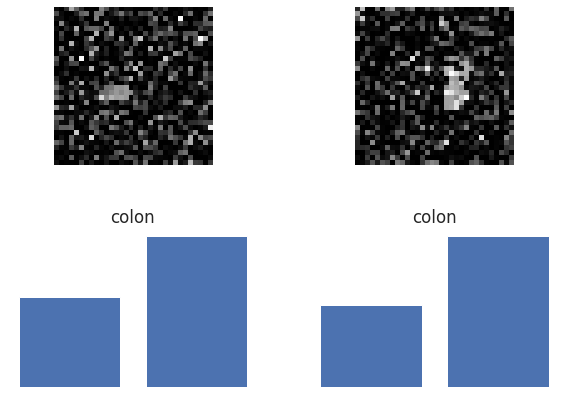

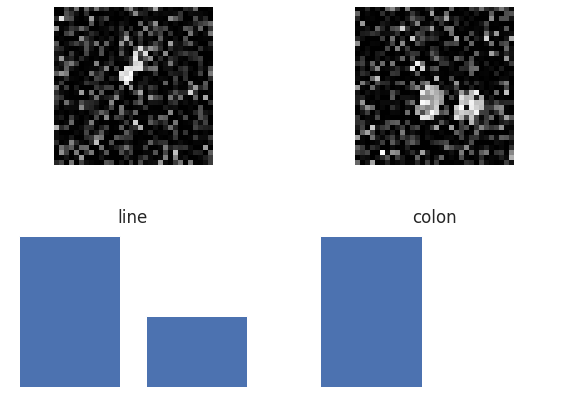

 
 
Extrapolation factor =  2.0
JPEG compression =  32
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


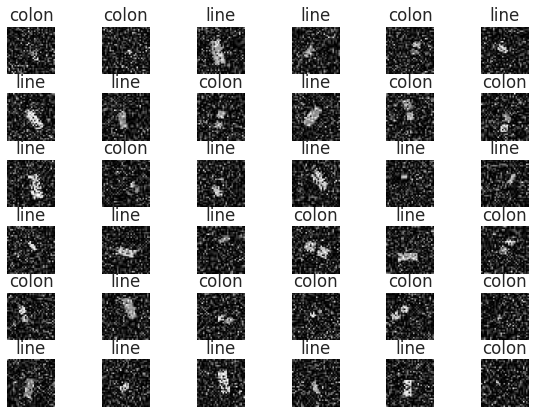

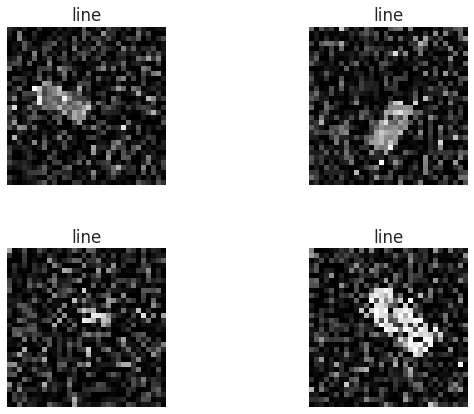

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.89760, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.89760

Epoch 00003: val_categorical_accuracy did not improve from 0.89760

Epoch 00004: val_categorical_accuracy improved from 0.89760 to 0.89830, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy improved from 0.89830 to 0.89850, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.89850

Epoch 00007: val_categorical_accuracy improved from 0.89850 to 0.90310, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.90310

Epoch 00009: val_categorical_accuracy did not improve from 0.90310

Epoch 00010: val_categorical_accuracy did not improve from 0.90310

Epoch 00011: val_categorical_accuracy did not improve from 0.90310

Epoch 00012: val_categorical_accuracy did not improve from 0.90310

Epoch 00013: val_categ

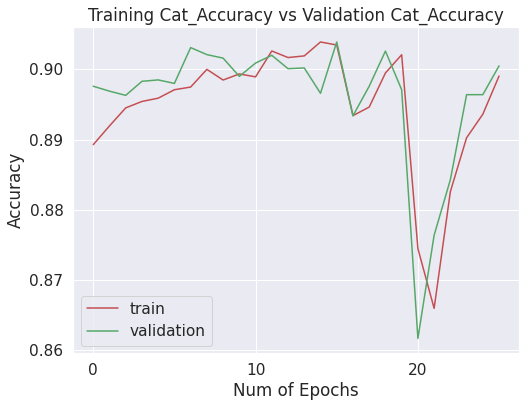

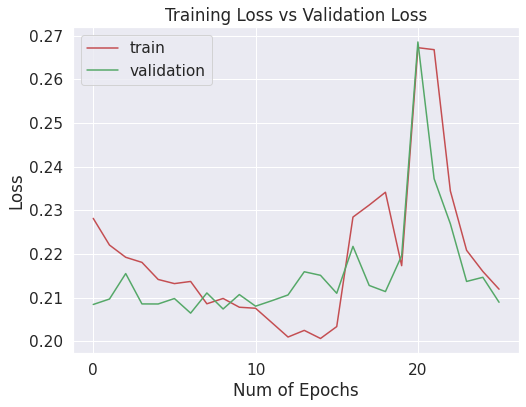

[[4312  653]
 [ 347 4688]]


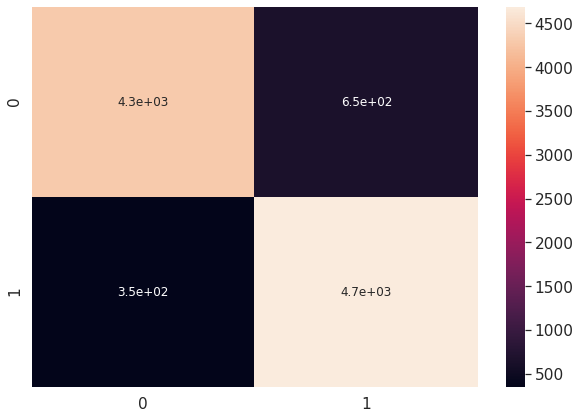

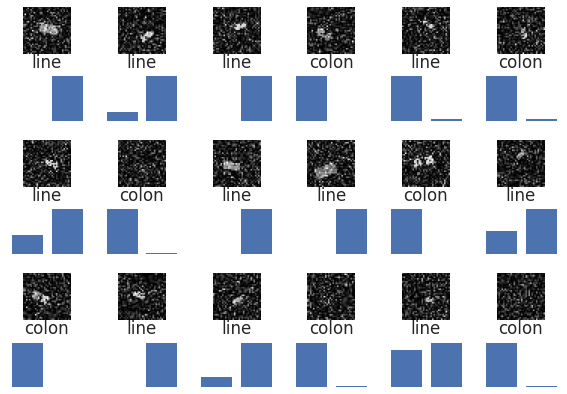

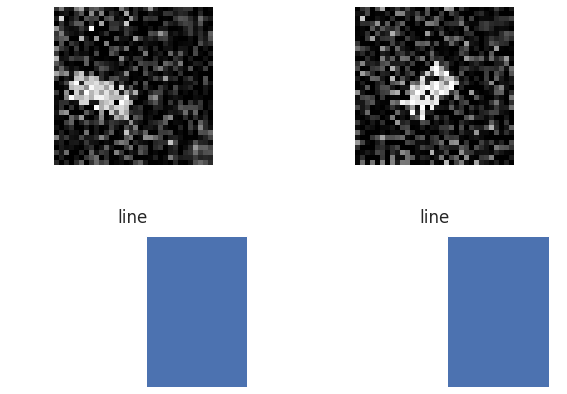

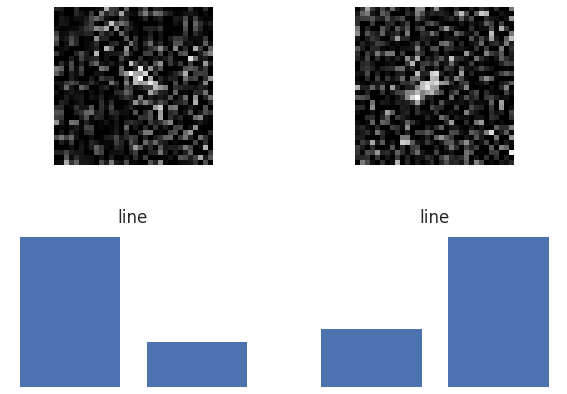

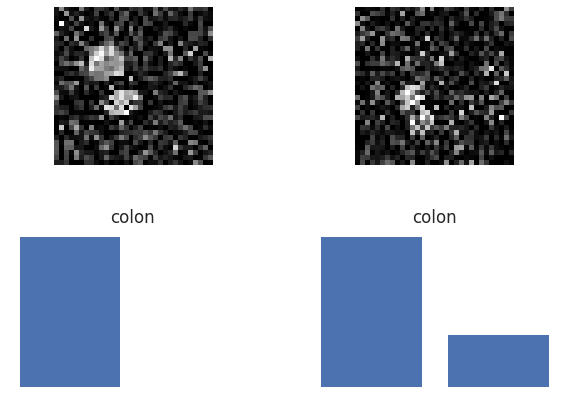

 
 
Extrapolation factor =  2.0
JPEG compression =  15
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


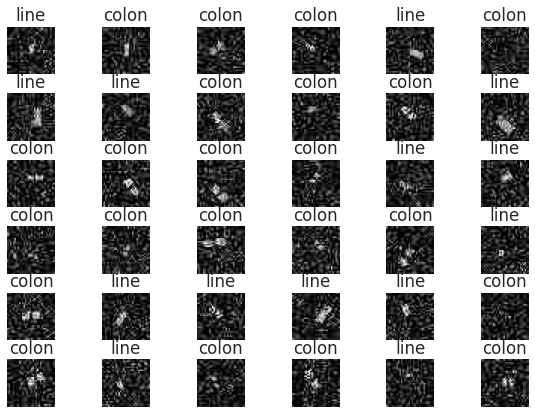

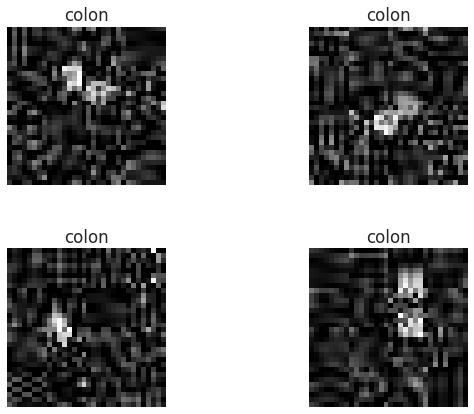

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88190, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.88190

Epoch 00003: val_categorical_accuracy did not improve from 0.88190

Epoch 00004: val_categorical_accuracy did not improve from 0.88190

Epoch 00005: val_categorical_accuracy did not improve from 0.88190

Epoch 00006: val_categorical_accuracy did not improve from 0.88190

Epoch 00007: val_categorical_accuracy did not improve from 0.88190

Epoch 00008: val_categorical_accuracy did not improve from 0.88190

Epoch 00009: val_categorical_accuracy did not improve from 0.88190

Epoch 00010: val_categorical_accuracy did not improve from 0.88190

Epoch 00011: val_categorical_accuracy did not improve from 0.88190
Epoch 00011: early stopping
Accuracy Train: 88.27% , Test: 88.19% Val: 88.16% 


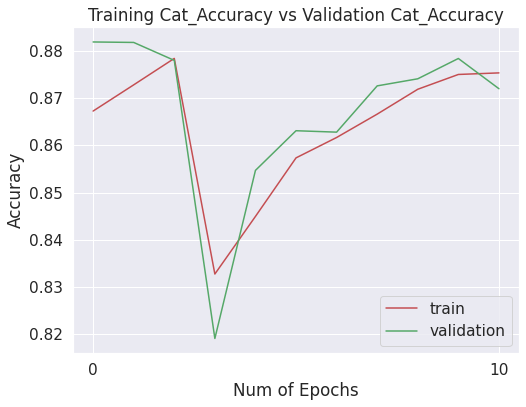

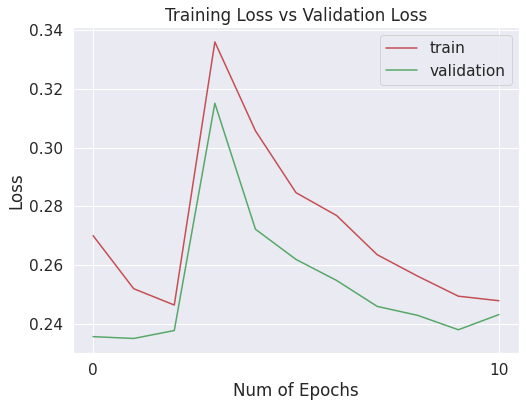

[[4289  820]
 [ 364 4527]]


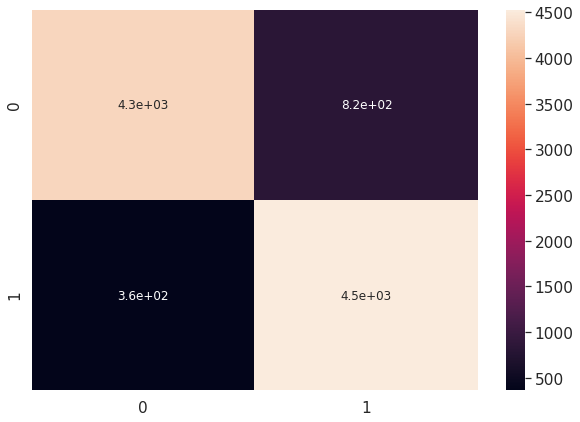

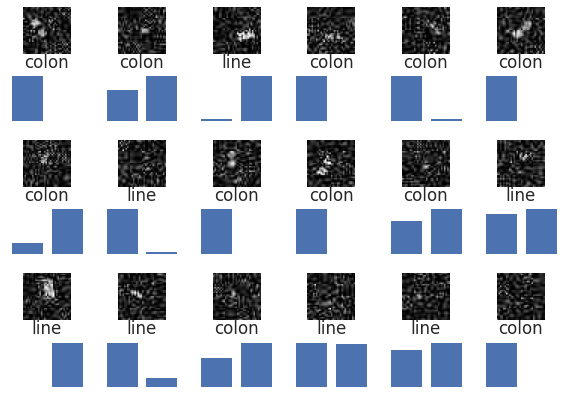

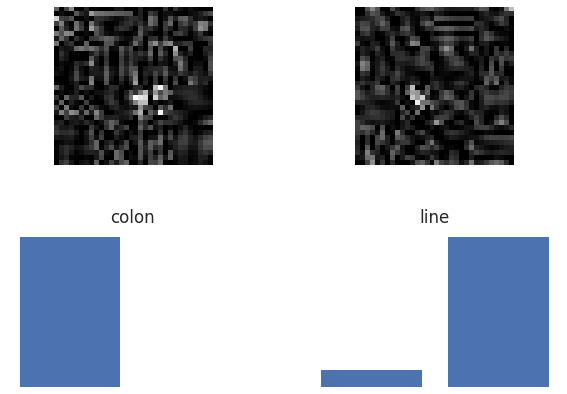

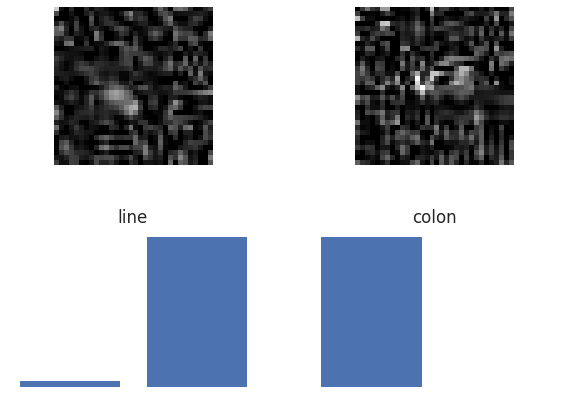

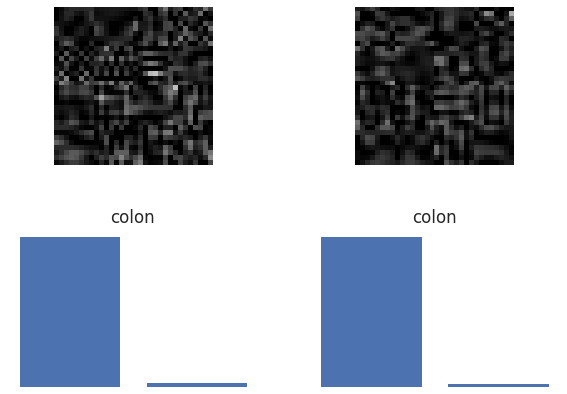

 
 
Extrapolation factor =  2.0
JPEG compression =  7
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


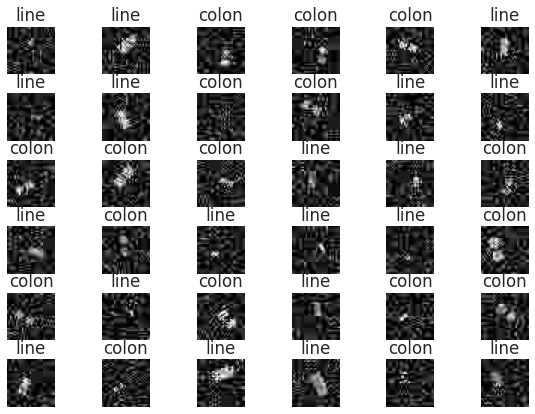

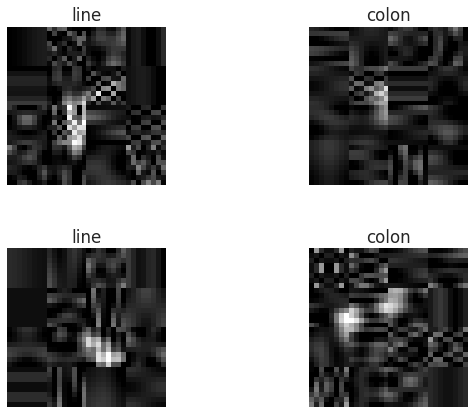

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86170, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.86170

Epoch 00003: val_categorical_accuracy improved from 0.86170 to 0.86270, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy improved from 0.86270 to 0.86590, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.86590

Epoch 00006: val_categorical_accuracy did not improve from 0.86590

Epoch 00007: val_categorical_accuracy did not improve from 0.86590

Epoch 00008: val_categorical_accuracy did not improve from 0.86590

Epoch 00009: val_categorical_accuracy did not improve from 0.86590

Epoch 00010: val_categorical_accuracy did not improve from 0.86590

Epoch 00011: val_categorical_accuracy improved from 0.86590 to 0.86730, saving model to best_model.h5

Epoch 00012: val_categorical_accuracy did not improve from 0.86730

Epoch 00013: val_categ

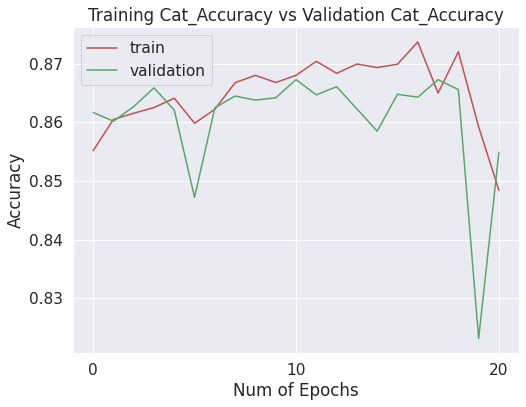

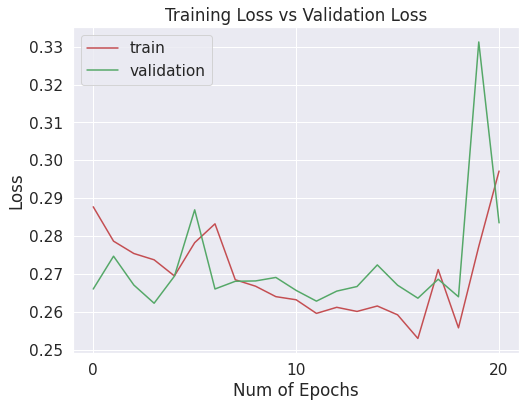

[[4205  798]
 [ 494 4503]]


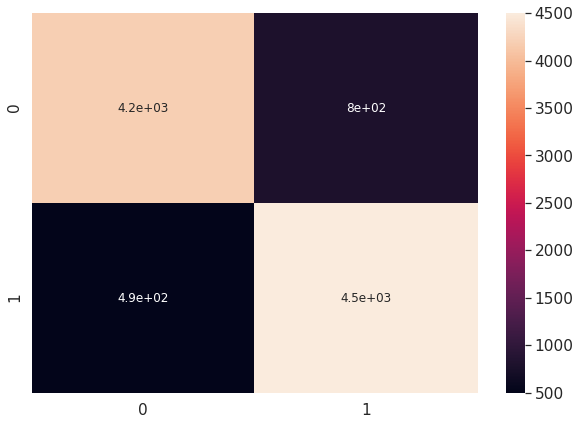

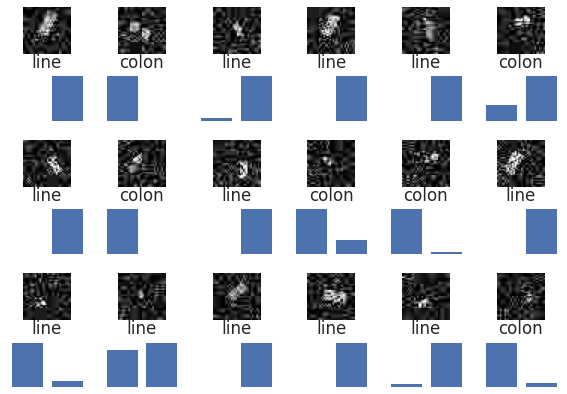

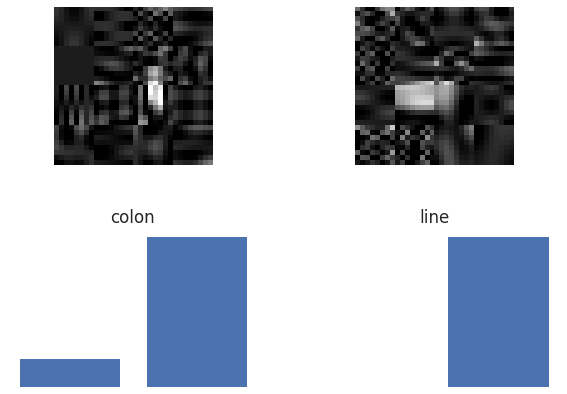

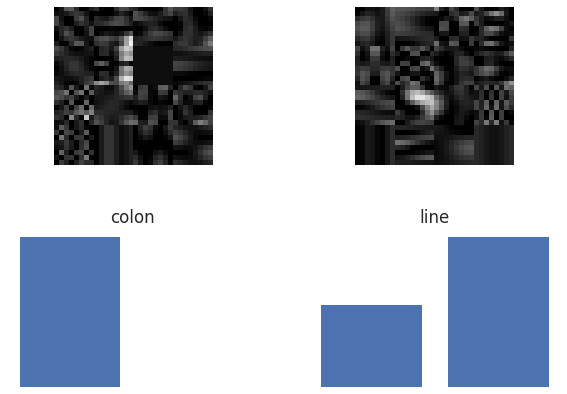

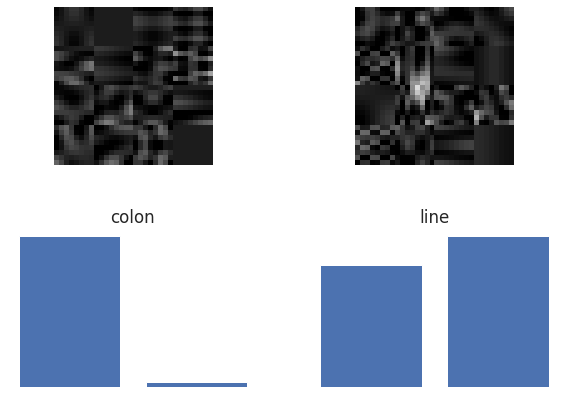

 
 
Extrapolation factor =  2.0
JPEG compression =  3
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


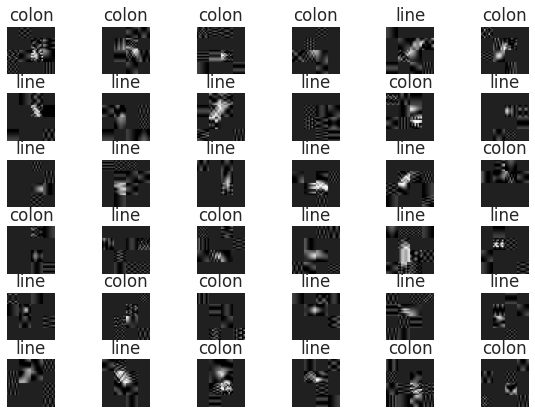

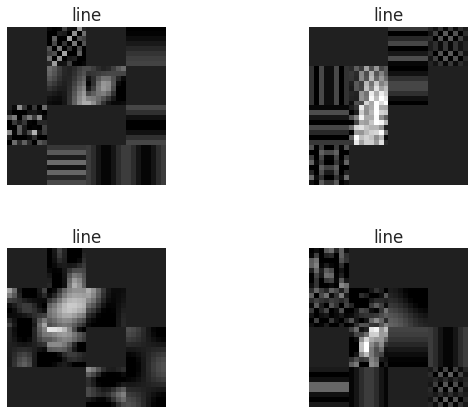

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.80470, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.80470 to 0.81050, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.81050

Epoch 00004: val_categorical_accuracy did not improve from 0.81050

Epoch 00005: val_categorical_accuracy did not improve from 0.81050

Epoch 00006: val_categorical_accuracy did not improve from 0.81050

Epoch 00007: val_categorical_accuracy did not improve from 0.81050

Epoch 00008: val_categorical_accuracy did not improve from 0.81050

Epoch 00009: val_categorical_accuracy did not improve from 0.81050

Epoch 00010: val_categorical_accuracy improved from 0.81050 to 0.81240, saving model to best_model.h5

Epoch 00011: val_categorical_accuracy did not improve from 0.81240

Epoch 00012: val_categorical_accuracy did not improve from 0.81240

Epoch 00013: val_categorical_accuracy did not improve fro

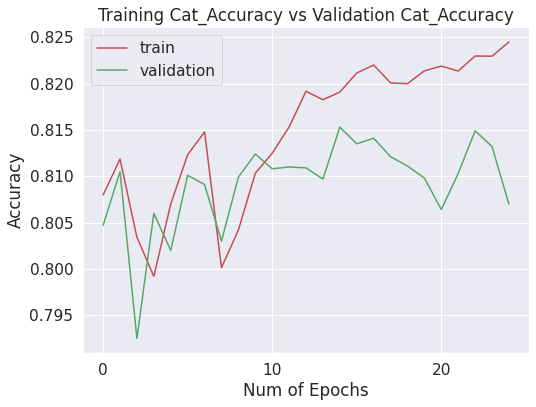

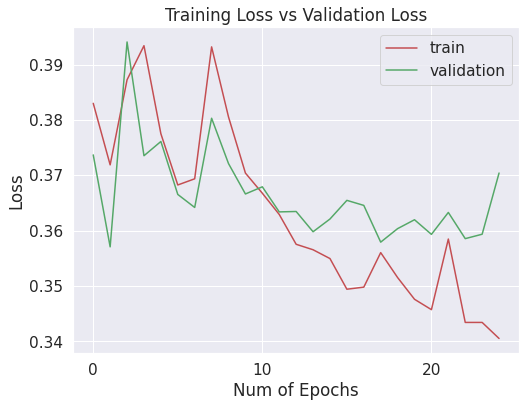

[[3776 1204]
 [ 617 4403]]


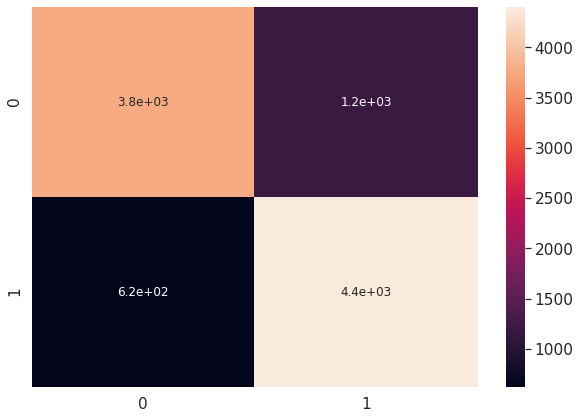

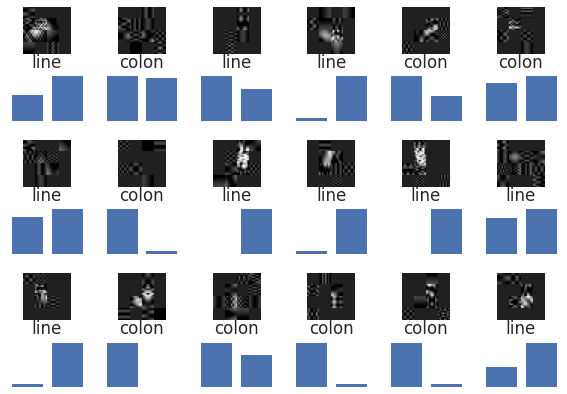

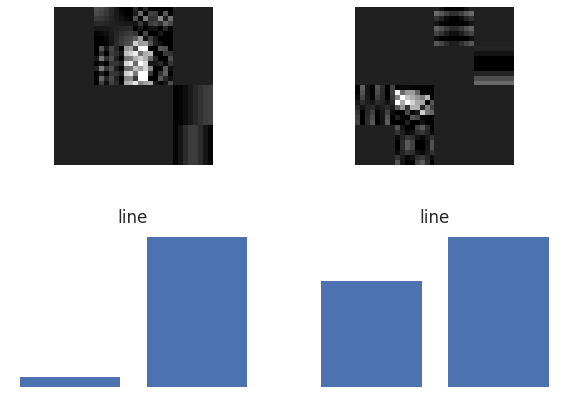

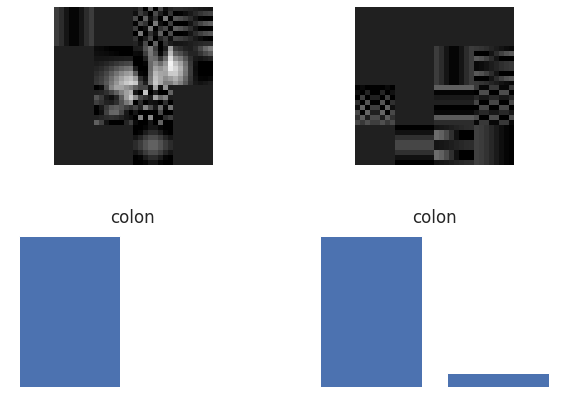

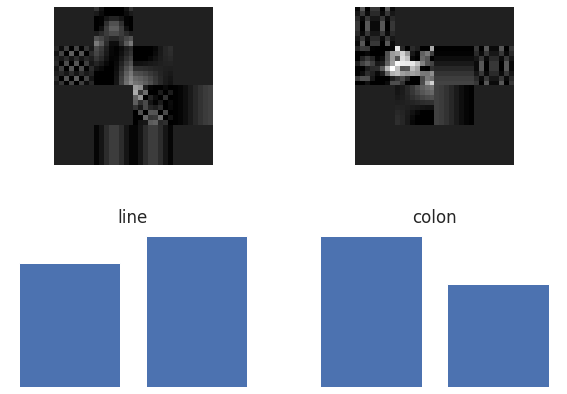

In [40]:
#acc_scores = []
#loss_scores = []

outcome = []

# Loop over extrapolations
for extrapolation_factor in extrapolation_list:

 # Loop over jpeg qualities
 if jpeg_format == 'jpeg':
   compression_list = jpeg_compression_list
 else:
  compression_list = jpeg2000_compression_list

 for jpeg_compression in compression_list:

   print(" ")
   print(" ")
   print("Extrapolation factor = ",extrapolation_factor)
   print("JPEG compression = ",jpeg_compression)
   print(" ")
   print(" ")
 
   # Generate data
   xx_train, xx_test, xx_val, yy_train, yy_test, yy_val, av_size = generate_datasets()

   #plot 100 figures (random offset)

   plot_images(6)


   plot_images(2)



   yy_train = np_utils.to_categorical(yy_train, num_classes)
   yy_test = np_utils.to_categorical(yy_test, num_classes)
   yy_val = np_utils.to_categorical(yy_val, num_classes)

   print("yy_train ",yy_train.shape)

   #Define the network
   cnn_n = base_model()
   # load the previously saved model
   try:
      cnn_n = load_model('best_model.h5')
   except:
      print("No saved model, training a new one.") 

   # patient early stopping
   es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
   mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

   # fit model
   cnn = cnn_n.fit(xx_train, yy_train, batch_size=batch_size, epochs=epochs, validation_data=(xx_test,yy_test),shuffle=True, callbacks=[es, mc], verbose=0)
   # load the saved model
   saved_model = load_model('best_model.h5')


   # evaluate loaded model
   scores_train = saved_model.evaluate(xx_train, yy_train, verbose=0)
   scores_test  = saved_model.evaluate(xx_test,  yy_test,  verbose=0)
   scores_val   = saved_model.evaluate(xx_val,   yy_val,   verbose=0)
   print("Accuracy Train: %.2f%% , Test: %.2f%% Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

   # add scores
#   acc_scores.append(scores_val[1]*100)
#   loss_scores.append(scores_val[0]*100)
   outcome_row = (extrapolation_factor, jpeg_compression, av_size, scores_val[1]*100, scores_val[0]*100)
   outcome.append(outcome_row)

   #Plot training results
   plot_training_results(cnn)
   # Confussion matrix result
   draw_confussion_matrix()

   # Plot classified images
   plot_results(6)


   plot_results(2)
   plot_results(2)
   plot_results(2)




# **ZIP images**

In [41]:
! zip images.zip images/* 
! cp images.zip /content/drive/My\ Drive/images_jpeg_nearest.zip

Streaming output truncated to the last 5000 lines.
  adding: images/image_extr_1.0_jpg_32_40.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_410.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_411.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_412.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_413.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_414.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_415.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_416.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_417.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_418.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_419.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_3_241.jpg (deflated 42%)
  adding: images/image_extr_1.0_jpg_32_41.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_420.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_32_421.jpg (deflated 1%)
  adding: images/image_extr_1.0_jpg_

# **Draw accuracy and loss vs. jpeg quality**

[(0.5, 97, 261109.924, 77.4399995803833, 44.31425527572632), (0.5, 80, 131161.28, 77.74999737739563, 43.78966914653778), (0.5, 32, 65733.012, 75.4800021648407, 47.144322919845585), (0.5, 15, 33465.98, 78.31000089645386, 41.4533150100708), (0.5, 7, 16741.768, 79.00000214576721, 41.1036041021347), (0.5, 3, 7557.82, 75.41999816894531, 46.003714647293094), (1.0, 97, 261335.154, 89.16000127792358, 22.869274263381957), (1.0, 80, 131145.36, 90.47999978065491, 19.850486781597137), (1.0, 32, 65635.518, 89.49000239372253, 21.331334183216093), (1.0, 15, 33486.898, 88.49999904632568, 23.013734772205353), (1.0, 7, 16725.32, 86.80999875068665, 26.19709433555603), (1.0, 3, 7687.346, 82.38999843597412, 34.76554031848907), (2.0, 97, 261387.004, 91.21000170707703, 18.897944270372392), (2.0, 80, 131250.984, 90.89999794960022, 19.215741441249847), (2.0, 32, 65584.906, 89.99999761581421, 21.254352848529816), (2.0, 15, 33468.99, 88.1600022315979, 23.637109463214877), (2.0, 7, 16969.946, 87.08000183105469, 2

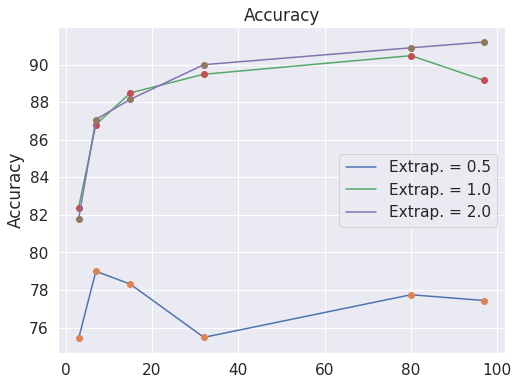

In [42]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     print(compr, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]) 
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)          
   else:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])



pyl.legend() 

pyl.title("Accuracy")
auxText = ""
if (jpeg_format == "JPEG2000"):
   auxText == "JPEG200 compression"
elif (jpeg_format == "jpeg"):
   auxText == "jpeg quality"  
pyl.xlabel(auxText)
pyl.ylabel("Accuracy")
pyl.show()


#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


[(0.5, 97, 261109.924, 77.4399995803833, 44.31425527572632), (0.5, 80, 131161.28, 77.74999737739563, 43.78966914653778), (0.5, 32, 65733.012, 75.4800021648407, 47.144322919845585), (0.5, 15, 33465.98, 78.31000089645386, 41.4533150100708), (0.5, 7, 16741.768, 79.00000214576721, 41.1036041021347), (0.5, 3, 7557.82, 75.41999816894531, 46.003714647293094), (1.0, 97, 261335.154, 89.16000127792358, 22.869274263381957), (1.0, 80, 131145.36, 90.47999978065491, 19.850486781597137), (1.0, 32, 65635.518, 89.49000239372253, 21.331334183216093), (1.0, 15, 33486.898, 88.49999904632568, 23.013734772205353), (1.0, 7, 16725.32, 86.80999875068665, 26.19709433555603), (1.0, 3, 7687.346, 82.38999843597412, 34.76554031848907), (2.0, 97, 261387.004, 91.21000170707703, 18.897944270372392), (2.0, 80, 131250.984, 90.89999794960022, 19.215741441249847), (2.0, 32, 65584.906, 89.99999761581421, 21.254352848529816), (2.0, 15, 33468.99, 88.1600022315979, 23.637109463214877), (2.0, 7, 16969.946, 87.08000183105469, 2

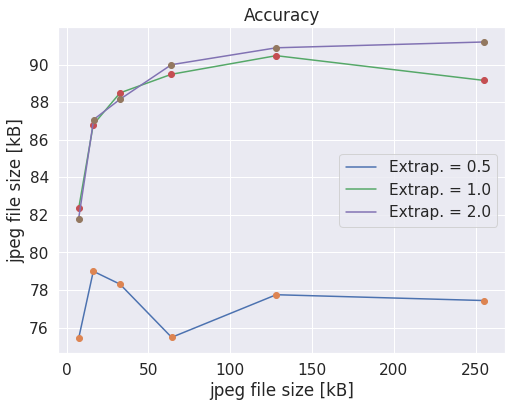

[255.26074609375, 128.1747890625, 64.047759765625, 32.684560546875, 16.572212890625, 7.374998046875]
[97, 80, 32, 15, 7, 3]
[91.21000170707703, 90.89999794960022, 89.99999761581421, 88.1600022315979, 87.08000183105469, 81.7900002002716]


In [43]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     #print(size, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]/1024.) 
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label) 
     print(size)
     print(compr)
     print(poly)         
   else:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)



pyl.legend() 

pyl.title("Accuracy")
auxText = jpeg_format+" file size [kB]"
pyl.xlabel(auxText)
pyl.ylabel(auxText)
pyl.show()

print(size)
print(compr)
print(poly)
#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


In [0]:
#plot loss
#pyl.plot(jpeg_compression_list, loss_scores)
#pyl.plot(jpeg_compression_list, loss_scores,'o')
#pyl.title("Loss")
#pyl.xlabel("JPEG quality")
#pyl.ylabel("Loss")
#pyl.show()